# 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import random
import warnings
import pickle

from scipy           import stats
from IPython.display import HTML
from IPython.display import Image
from tabulate        import tabulate
from boruta          import BorutaPy

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

C:\Users\eliel\AppData\Roaming\Python\Python310\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.1 Helper Functions

In [2]:
def cross_validation(x_training, kfold, model_name, model):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in range(1, kfold + 1):
        datetime.datetime.now()
        print('\nKFolder = {}'.format(k))
    
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k - 1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        xtraining = training.drop(['date','sales'], axis = 1)
        ytraining = training['sales']

        xvalidation = validation.drop(['date','sales'], axis = 1)
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining)

        # prediction 
        yhat = m.predict( xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name':model_name,
                        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index = [0])

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat)/y)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name':model_name,'MAE':mae,'MAPE':mape,'RMSE':rmse}, index = [0])

def v_cramer( x , y ):
    cm = np.matrix(pd.crosstab( x, y ))
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k - 1)*(r - 1)/(n - 1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / min(kcorr - 1, rcorr - 1))    

def jupyter_setting():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 12
    
    display( HTML('<style>.container {width:100% !important;} </styel>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False)

In [3]:
jupyter_setting();

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Program Files\Python310\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory = False)
df_store_raw = pd.read_csv( 'data/store.csv', low_memory = False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
210353,734,6,2015-01-24,2426,228,1,0,0,0,a,a,220.0,NaN,NaN,1,36.0,2013.0,"Mar,Jun,Sept,Dec"


# 1.0 PASSO 1.0 - DATA DESCRIPTION

### Qual a motivação da descrição dos dados?
__Para saber o quão desafiador é o poroblama que eu estou lidando!__

## 1.1 Rename Columns

In [5]:
df1 = df_raw.copy()

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 
            'PromoInterval']

snake_case = lambda x:  inflection.underscore( x ) # convert cammel casa para snake case
cols_new = list( map( snake_case, cols_old))

df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [7]:
print('Number of rows = {}'.format(df1.shape[0]))
print('Number of columns = {}'.format(df1.shape[1]))

Number of rows = 1017209
Number of columns = 18


## 1.3 Data Typers

In [8]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
# competition_distance --> fill na by a very large distance 
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 5*df1['competition_distance'].max() if math.isnan( x ) else x)

# competition_open_since_month  
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1 )  

# competition_open_since_year    
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1 )  

# promo2_since_week   
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1 )  

# promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1 )

# promo_interval
month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0  else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1 )

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descriptive Statistical

In [13]:
# Split the dateframe into two subset. One quantitative and another categorical.
num_atributes = df1.select_dtypes(include = ['int64', 'float64'] )
cat_atributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]' ] )

### 1.7.1 Quantitative Attributes

In [14]:
# Central Tendence - mean and median
ct1 = pd.DataFrame( num_atributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_atributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew and kurtosis
d1 = pd.DataFrame( num_atributes.apply ( np.std )).T
d2 = pd.DataFrame( num_atributes.apply ( min )).T 
d3 = pd.DataFrame( num_atributes.apply ( max )).T 
d4 = pd.DataFrame( num_atributes.apply ( lambda x: x.max() - x.min() )).T 
d5 = pd.DataFrame( num_atributes.apply (lambda x: x.skew() )).T 
d6 = pd.DataFrame( num_atributes.apply ( lambda x: x.kurtosis() )).T 

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,379300.0,379280.0,6401.139107,2330.0,20529.887501,15.699494,280.001870
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.165966,0.0,0.372050,1.795644,1.224338


### 1.7.2 Categorical Attributes

In [15]:
# for col in cat_atributes.columns:
#     print(col)
#     print(cat_atributes[col].value_counts())
cat_atributes.apply( lambda x: x.unique().shape[0] ).T

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

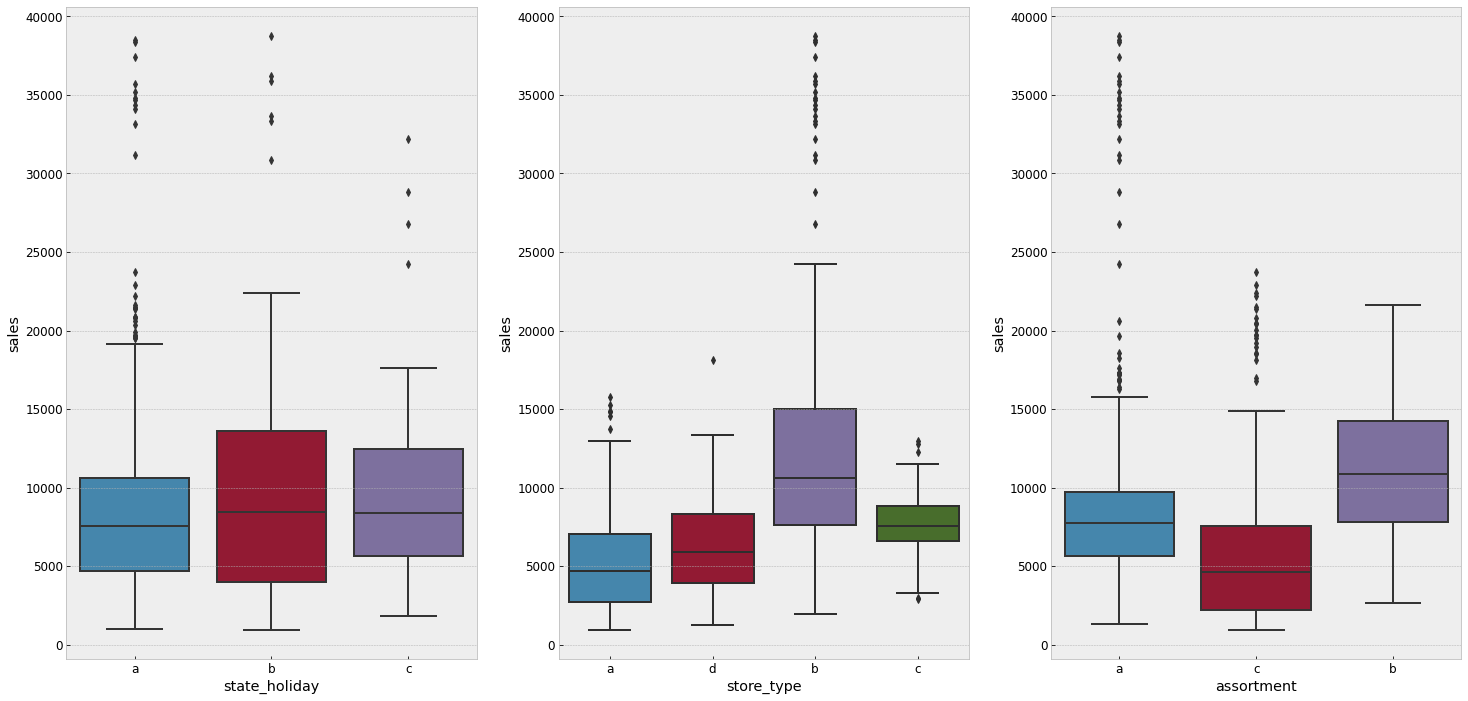

In [16]:
aux1 = df1[( df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot( x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.boxplot( x = 'store_type', y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.boxplot( x = 'assortment', y = 'sales', data = aux1)

# 2.0 PASSO 2.0 - FEATURE ENGINEERING

**Por que?** Para ter as variáveis disponíveis para estudo durante a análise exploratória de dados.

In [17]:
df2 = df1.copy()

## 2.1 Miding Map Hypothesis

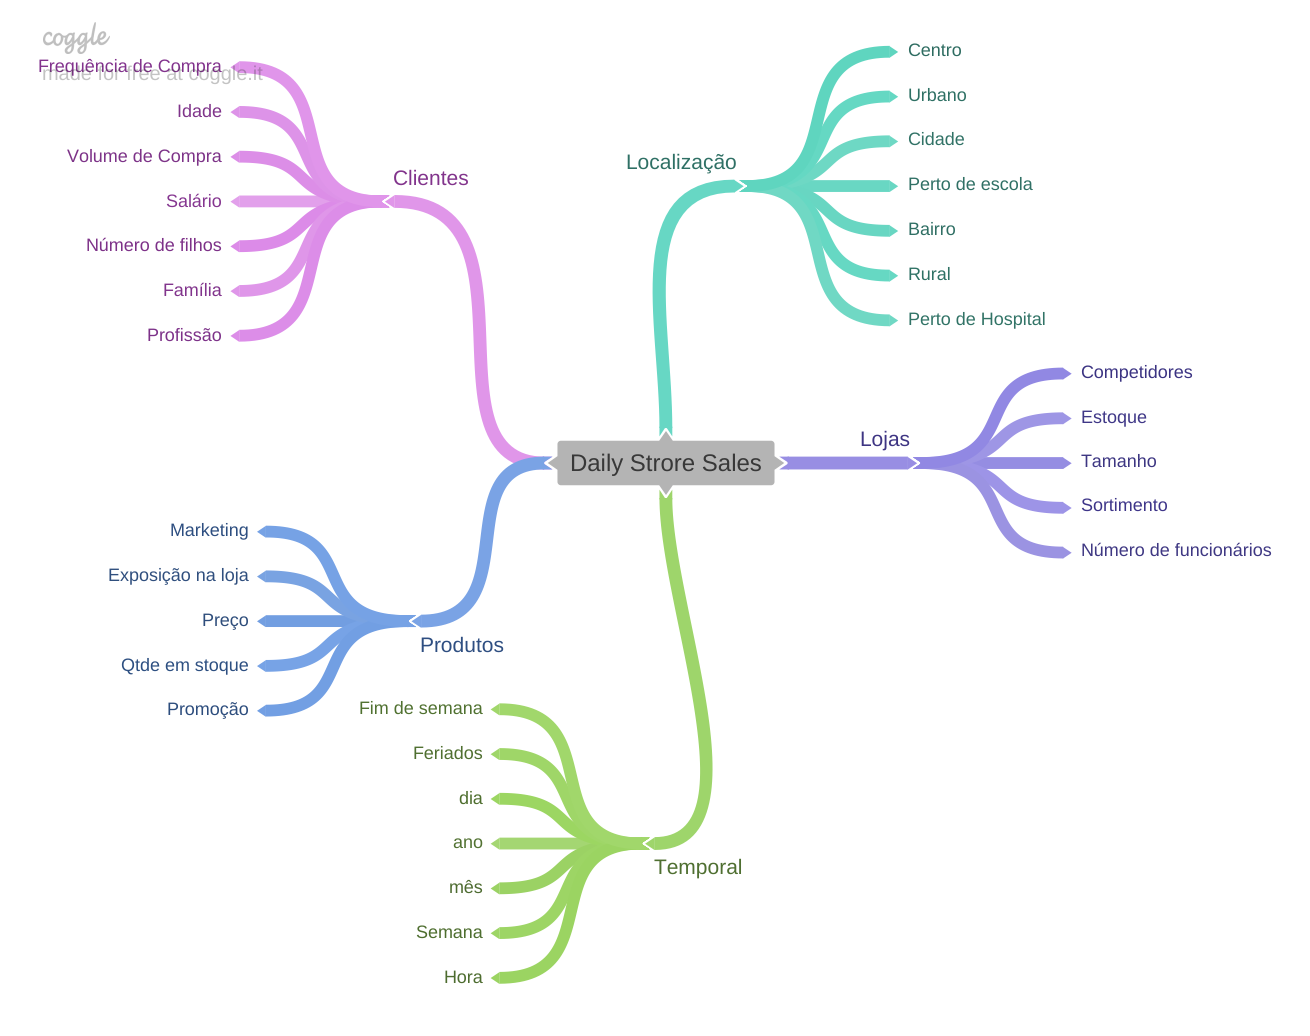

In [18]:
Image('img/Mind_maps_Hypothesis.png')

## 2.2 Hypothesis Criation

### 2.2.1 Store Hypothesis

**1.** Sotores with higher number of employes should have more sales

**2.** Sotores with higher storage capacity should have more sales

**3.** The bigest sotores should have more sales

**4.** Sotores with higher sortmment should have more sales

**5.** Sotores closest competitors should have less sales

**6.** Sotores with long term competitors should have more sales

### 2.2.2 Product Hypothesis

**1.** Stores with higher marketing investiments should have more sales.

**2.** Stores with higher products exposition should have more sales.

**3.** Stores with higher marketing investiments should have more sales.

**4.** Stores with products lower prices should have more sales.

**5.** Stores with agressive promo (more discounts) should have more sales.

**6.** Stores with long term promo should have more sales.

**7.** Stores with consecutive promos should have more sales.

**8.** Stores with more days in promos should have more sales.

### 2.2.3 Time Hypothesis

**1.** Openned stores during the christmans holydar should have more sales

**2.** The sales should increase along years

**3.** The sales should be higher in the second semestrer of the year

**4.** The sales should be higher in days after 10.

**5.** The sales shuould be lower in the weekends.

**6.** The sales shuould be lower in schools holydays.

### 2.2.4 Final Hypothesis list
The final hypothesis list must include the easiest test hypothesis. A simple criterio for that is select hypotesis that you have the data.


**1.** Sotores with higher assortment should have more sales

**2.** Sotores closest competitors should have less sales

**3.** Sotores with long term competitors should have more sales

**4.** Stores with agressive promo (more discounts) should have more sales.

**5.** Stores with long term promo should have more sales.

**6.** Stores with consecutive promos should have more sales.

**7.** Openned stores during the christmans holydar should have more sales

**8.** The sales should increase along years

**9.** The sales should be higher in the second semestrer of the year

**10.** The sales should be higher in days after 10.

**11.** The sales shuould be lower in the weekends.

**12.** The sales shuould be lower in schools holydays.

### 2.2.5 Feature Engineering

In [19]:
# year
df2['year'] = df2['date'].dt.year

# monthy
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ( (df2['date'] -  df2['competition_since'])/30 ).apply(lambda x: x.days).astype ( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( (lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7)))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype( int )

# assortiment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular day')

C:\Users\eliel\AppData\Local\Temp\ipykernel_25204\2259855138.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [20]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular day,regular day,regular day,regular day,regular day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 PASSO 3.0 - VARIABLES FILTERING

**Por que?** Para ter as variáveis disponíveis para estudo durante a análise exploratória de dados.

In [21]:
df3 = df2.copy()

## 3.1 Filtragem de linhas

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção de colunas

In [23]:
cols_drop = ['customers','open','promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

# 4.0 PASSO 4.0 - EXPLORATORY DATA ANALYSIS

**Objetivos**:    

**1**: Ganhar experiência de Negócio.   
**3**: Validar Hipóteses de Negócio. (Insights)   
**3**: Perceber Varáveis que são Importantes para o Modelo.

**Tipos de Análises**:   

**Análise Univaridda:** Como é a variável? ( min, max, distribuição, range, ...)   
**Análise Bivariada:** Como a variável impacta na resposa? Correlação, validação das Hóteses,...)    
**Análise Multivariada:** Como as variáveis se relavionam? Qual a correlação entre elas?

In [24]:
df4 = df3.copy()

## 4.1 Análise univariada

### 4.1.1 Response Variable

C:\Users\eliel\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


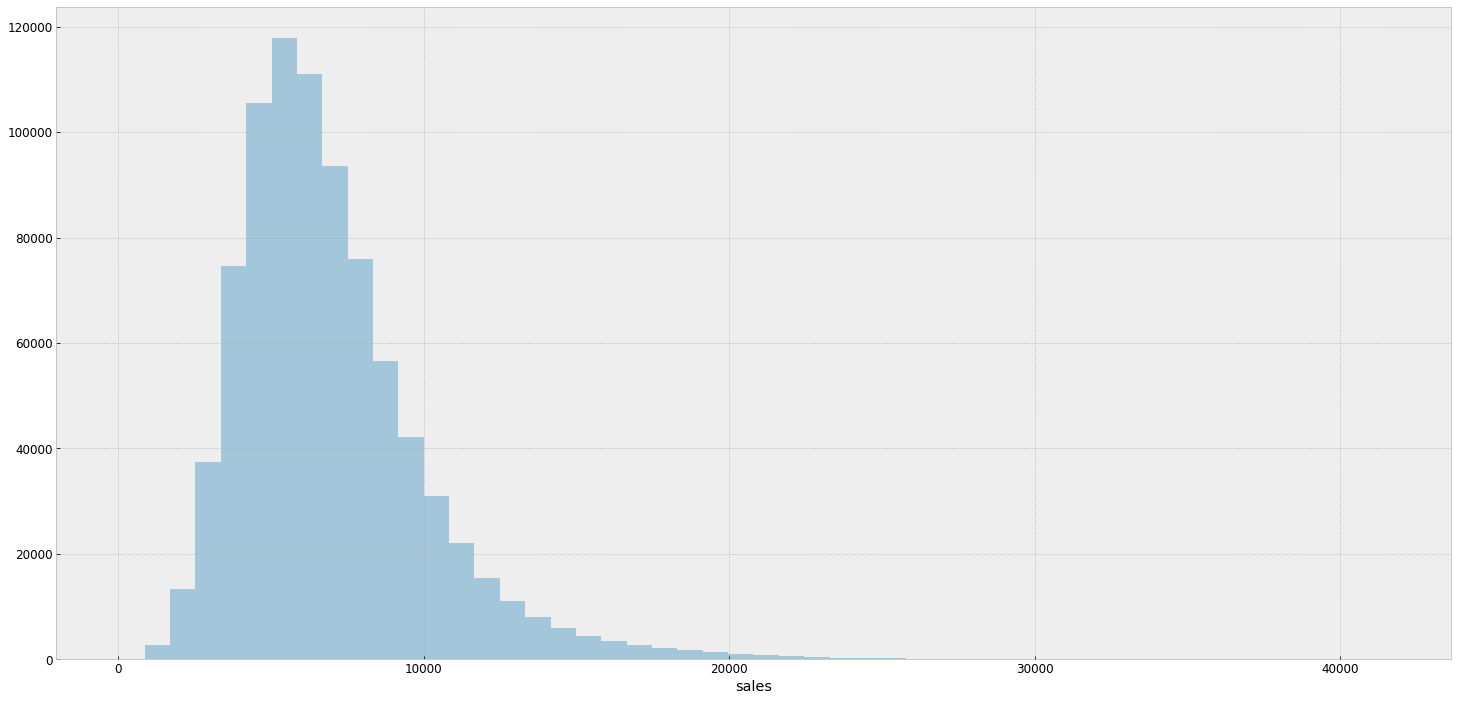

In [25]:
sns.distplot(df4['sales'], kde = False);

### 4.1.2 Numerical Variable

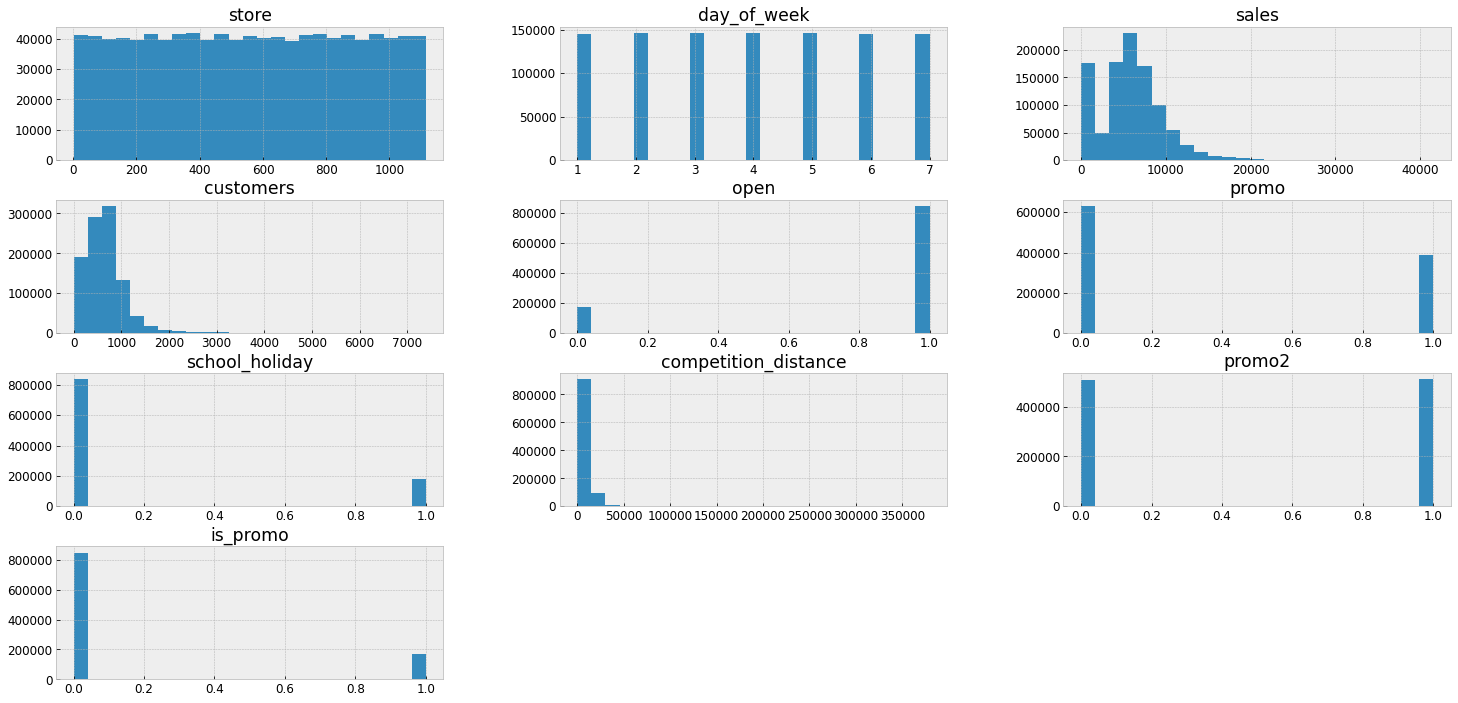

In [26]:
num_atributes.hist(bins = 25);
# aux = num_atributes[num_atributes['competition_distance'] < 300000]['competition_distance'].hist(bins = 25)

### Task: Write the one sentence descriptin for each chart above.
**Stores:** Rectangular shape with mean at 600 range of 1000 ( 0 to 1000 ) and no aparent outliers.   
**Day of week:** Rectangular shape with mean at 4 range of 7 ( 0 to 7 ) and no aparent outliers.   
**Sales** Right skewed, median roughlly 7000, men roughlly 7500 range of 40000 ( 0 to 40000 ), with most part of data from 2000 up to 11000, outlier in the higher and.   
**Customes** Right skewed, median roughlly 800, mean roughlly 850, range of 6000 ( 0 to 6000), with most part of data from 0 up to 1700 and outlier on the higher end.   
**Competition Distance:** Right skewed median roughlly 500, mean roughlly 600, range 7500 ( 0 to 7500 ), with most part of data from 0 up to 1500 and outliers on the giher end.   
**competition open since month:** Roughlly Bell-Shape, tri-modal, meidian and mean roughlly 7, range 12 ( 0 to 12 ) and no aparent outlires.   
**competition open since year:** Left skewed, median roughlly 2010 mean roughlly 2009, range 120 ( 1900 t0 2020 ), with most part of data from 2000 up to 2010, and outliers on the very begin.   
**promo since week:** No regular shape, median and mean roughlly 25, range 50 ( 0 to 50 ) and no aparent outliers.   
**promo since year:** Left skewed, median roughlly 2014, mean roughlly 2013, range 6 years ( 2009 to 2015 ) and no aparent outlies.   
**No comments for**: Open, promo, promo3, scholl holiday,  is promo, 

### 4.1.3 Categorical Variable

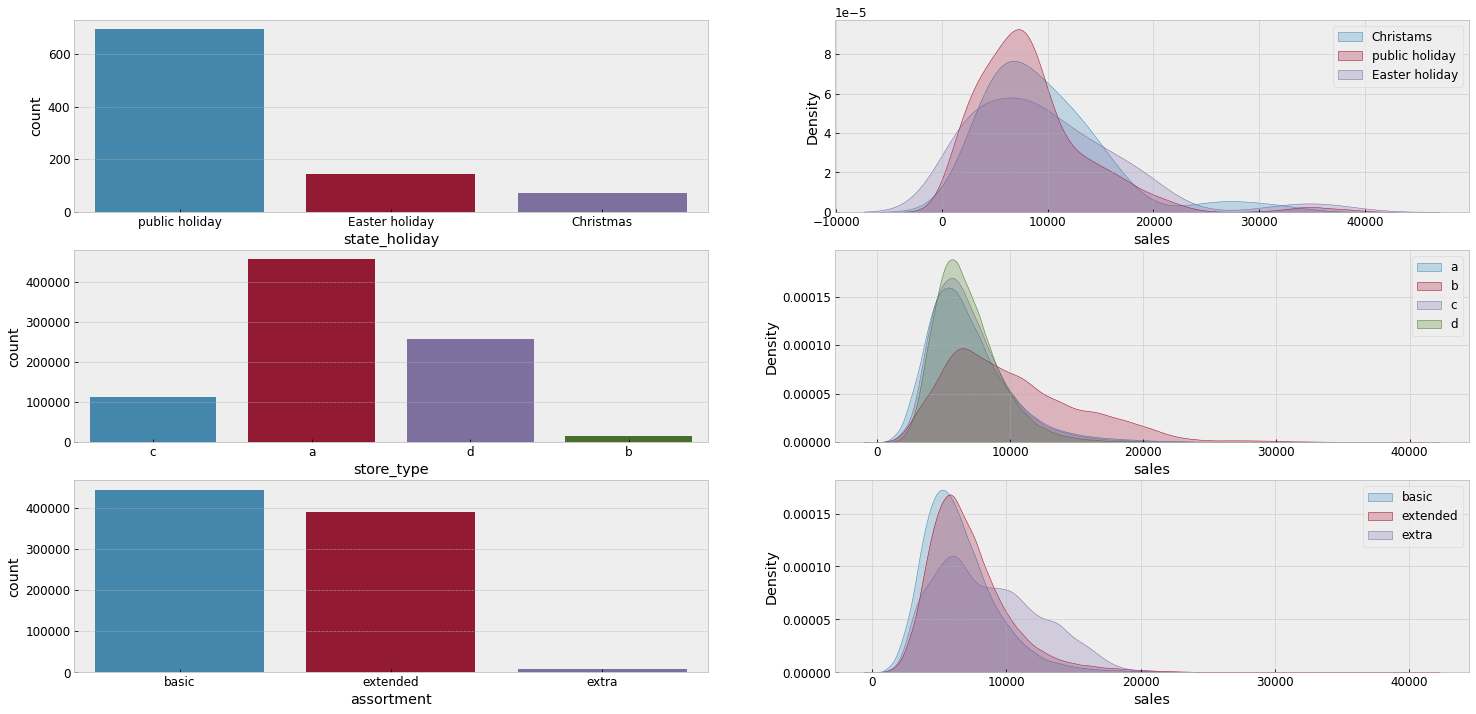

In [27]:
# State Holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular day']
sns.countplot(x = a['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'], label = 'Christams', shade = True);
sns.kdeplot(df4[df4['state_holiday'] == 'public holiday']['sales'], label = 'public holiday', shade = True);
sns.kdeplot(df4[df4['state_holiday'] == 'Easter holiday']['sales'], label = 'Easter holiday', shade = True);
plt.legend()

# store type
plt.subplot(3,2,3)
sns.countplot(x =  df4['store_type']);

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True);
plt.legend()


# assortment
plt.subplot(3,2,5)
sns.countplot(x = df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True);
plt.legend()

plt.show()

## 4.2 Análise Bivariada

### **H1.** Sotores with higher assortment should have more sales
**Refuted** Stores with higher assortment have less sales.



<AxesSubplot:xlabel='year_week'>

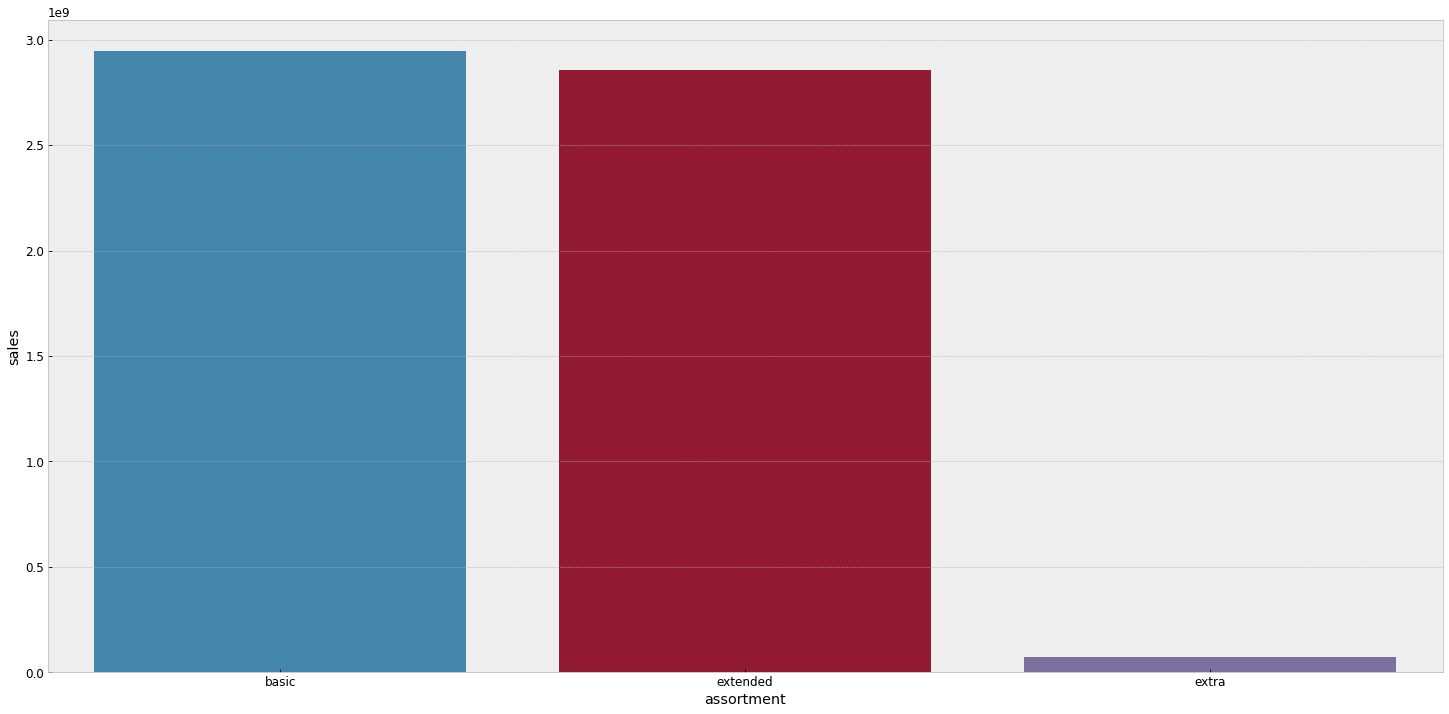

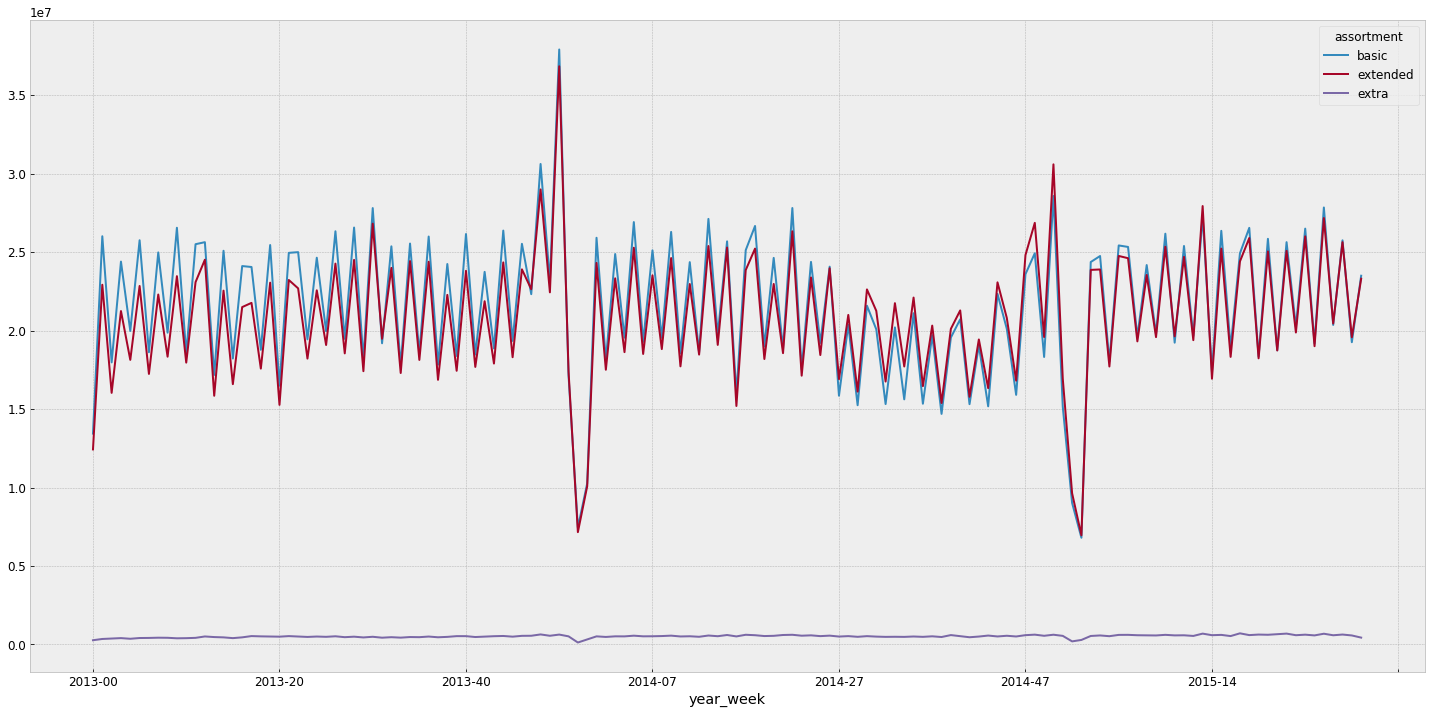

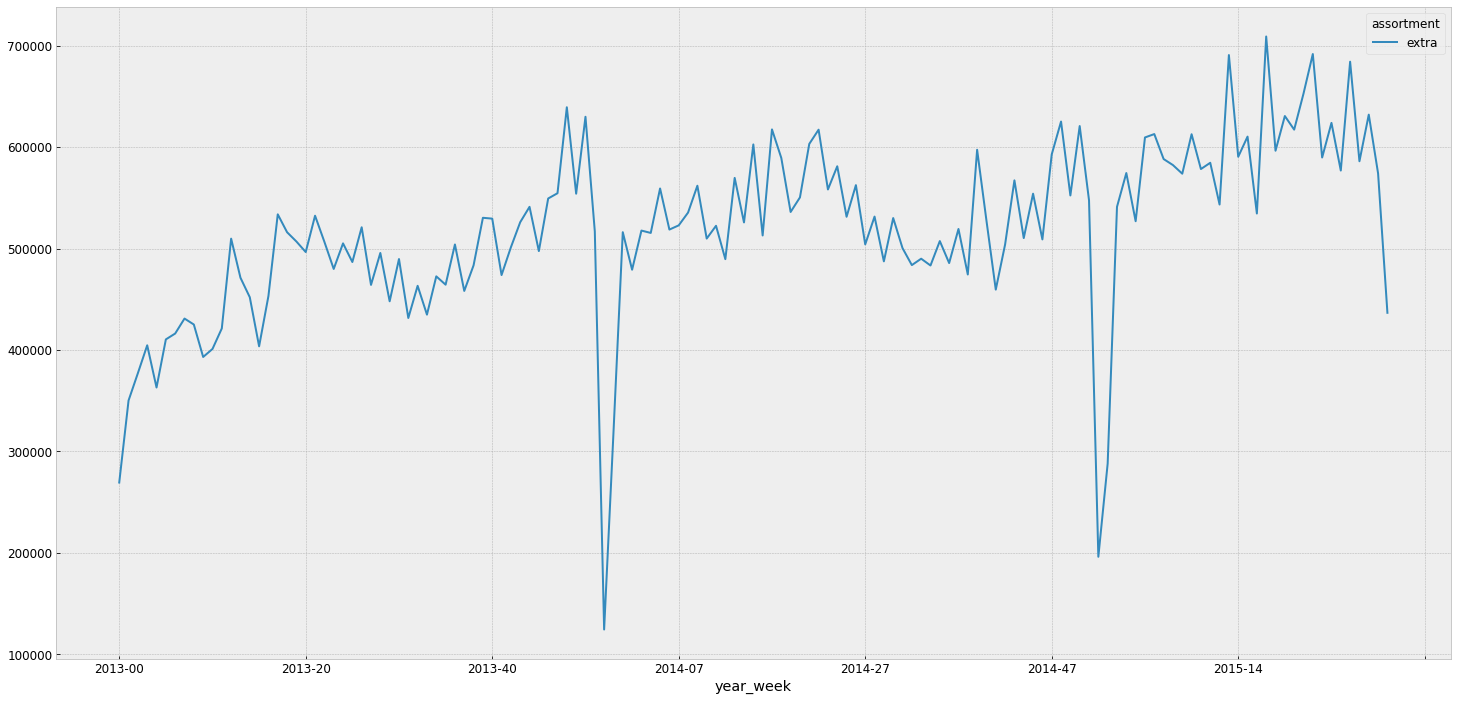

In [28]:
sns.barplot(x = 'assortment', y = 'sales', data = df4);

aux1 = df4[['assortment','sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

aux2 = df4[['year_week', 'assortment','sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

aux3 =  aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

### **H2.** Sotores closest competitors should have less sales
**Refuted** Stores with closes competitors have more sales

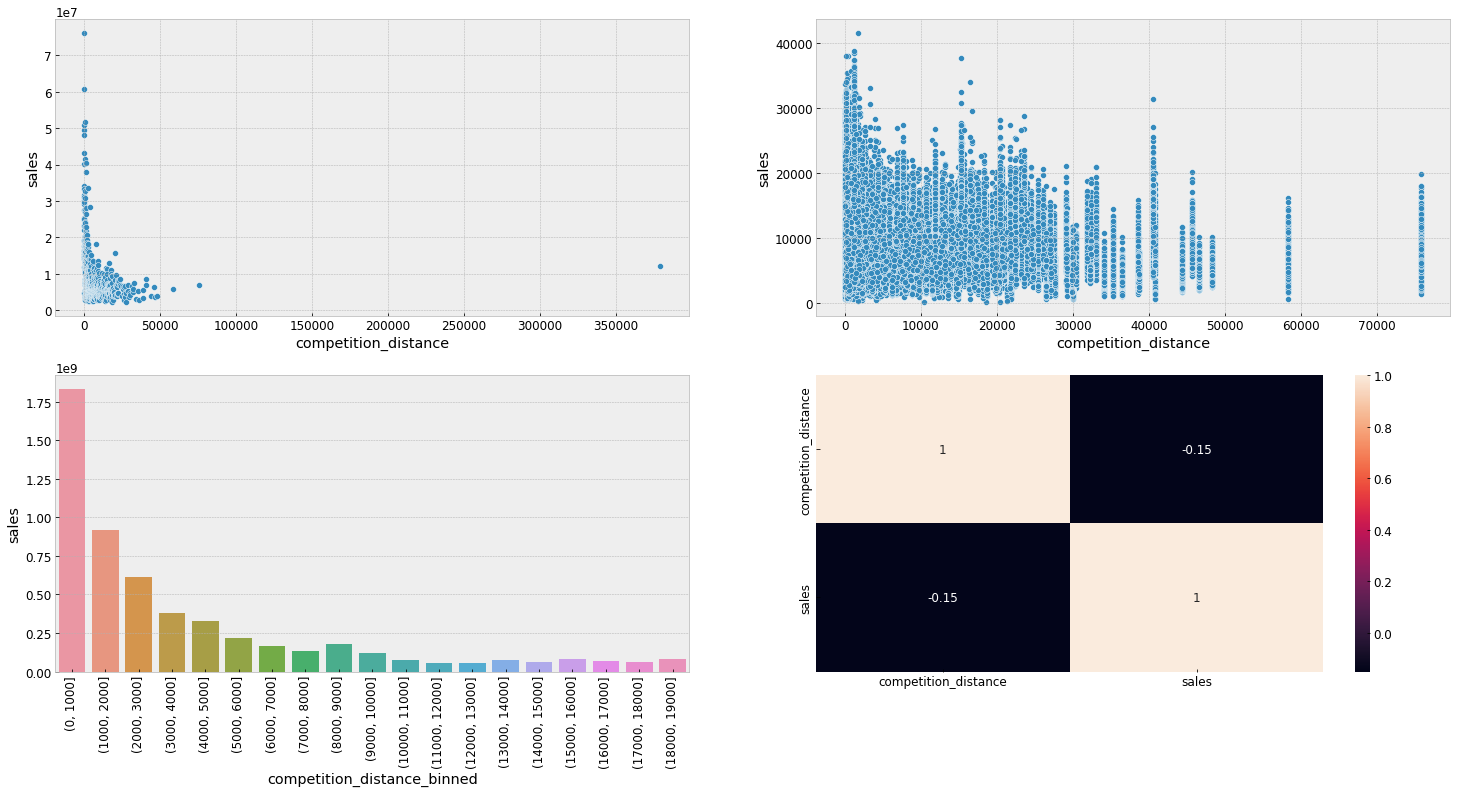

In [29]:
aux1 = df4[['competition_distance','sales']].groupby( 'competition_distance').sum().reset_index()
plt.subplot(2,2,1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(2,2,2)
aux2 = df4[df4['competition_distance'] <  df4['competition_distance'].max()]
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux2);

plt.subplot(2,2,3) 
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux3 = aux1[['competition_distance_binned','sales']].groupby( 'competition_distance_binned').sum().reset_index()
# aux3['competition_distance_binned'] = aux3['competition_distance_binned'].astype( str )
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux3); 
plt.xticks(rotation = 90);

plt.subplot(2,2,4)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);


### **H3.** Sotores with long term competitors should have more sales
**Refute** Stores wtih long term competitors have less sales.

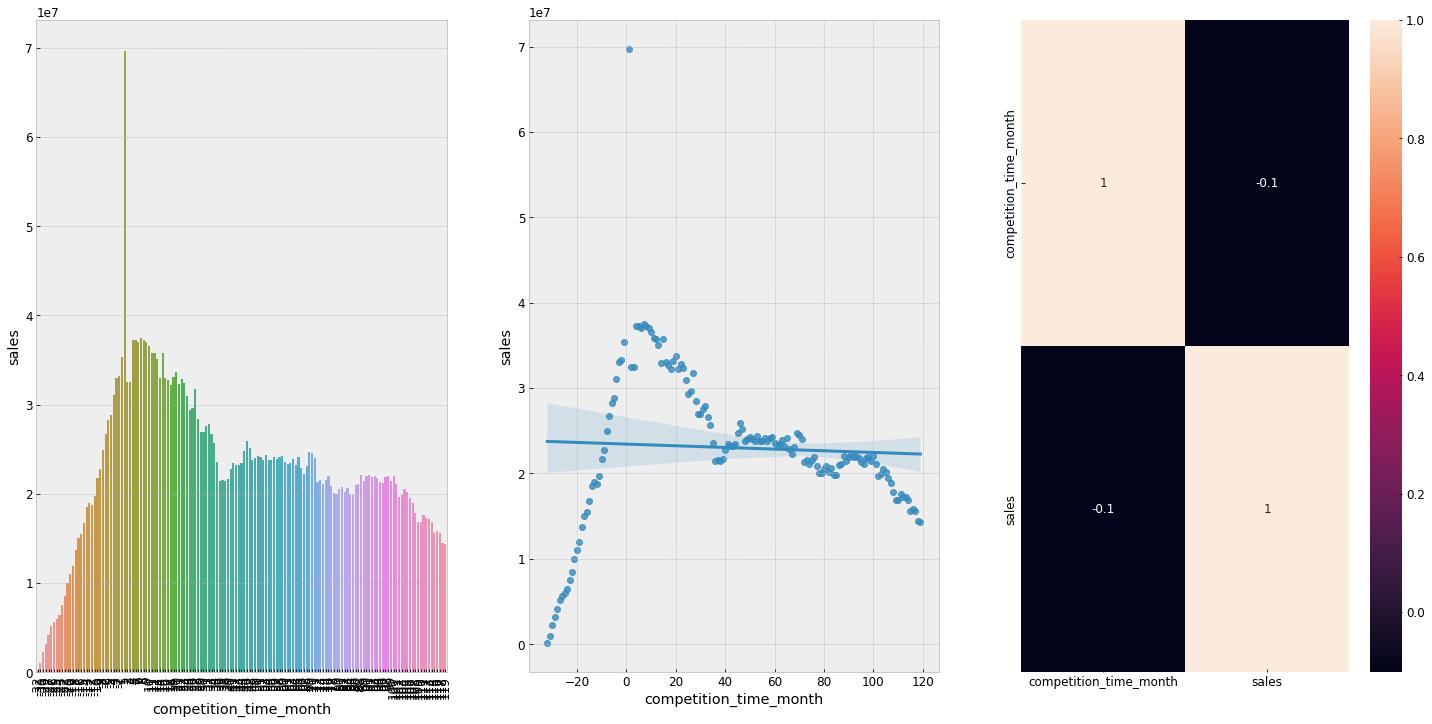

In [30]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True );

### **H4**. Stores with long term promo should have more sales.
**Refuted** Stores with long term promo have less sales after some period.

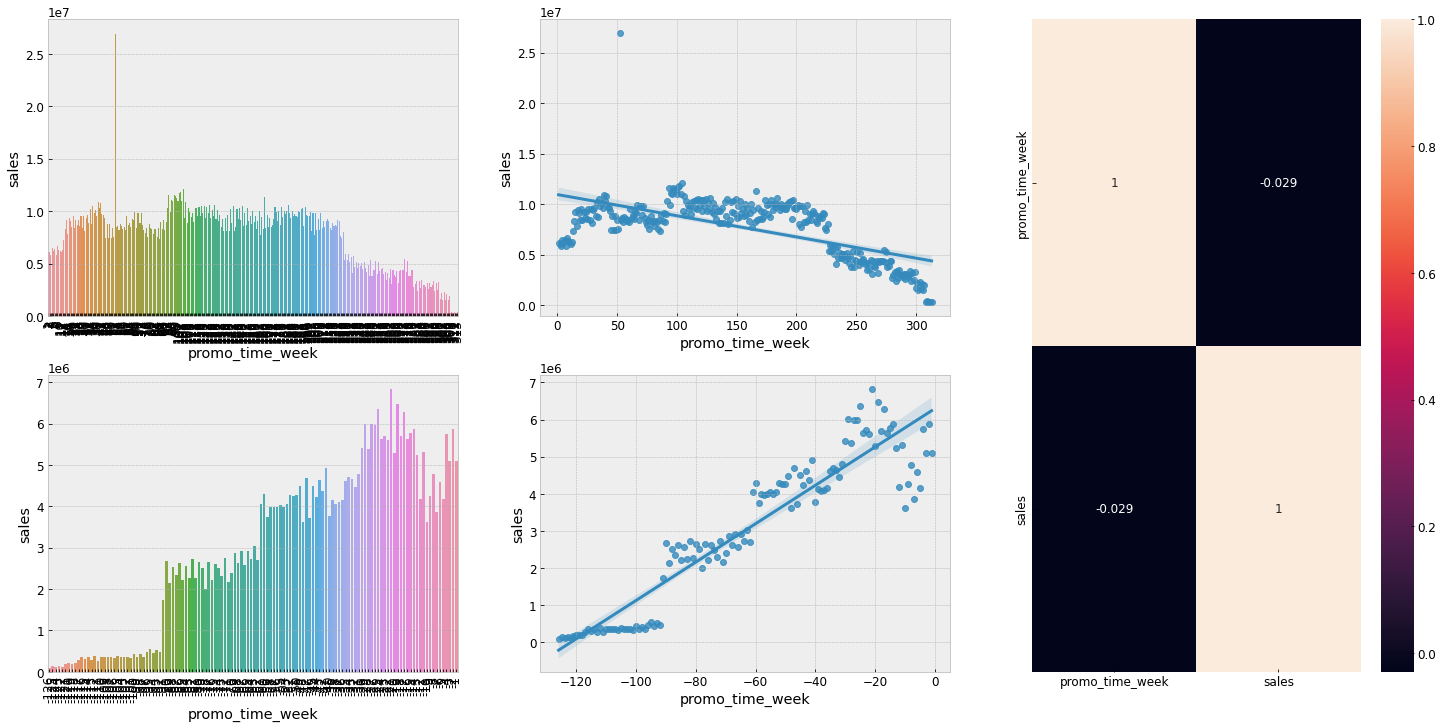

In [31]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
grid = GridSpec(2, 3)
plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promoção extendida
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1,0])
aux3= aux1[aux1['promo_time_week'] < 0] # promoção regular
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);


### <s>**H8.** Stores with more days in promo should have more sales.</s>


### **H5**. Stores with consecutive promos should have more sales.
**Refuted** Stores with consecutive promos havel less sales.

In [32]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


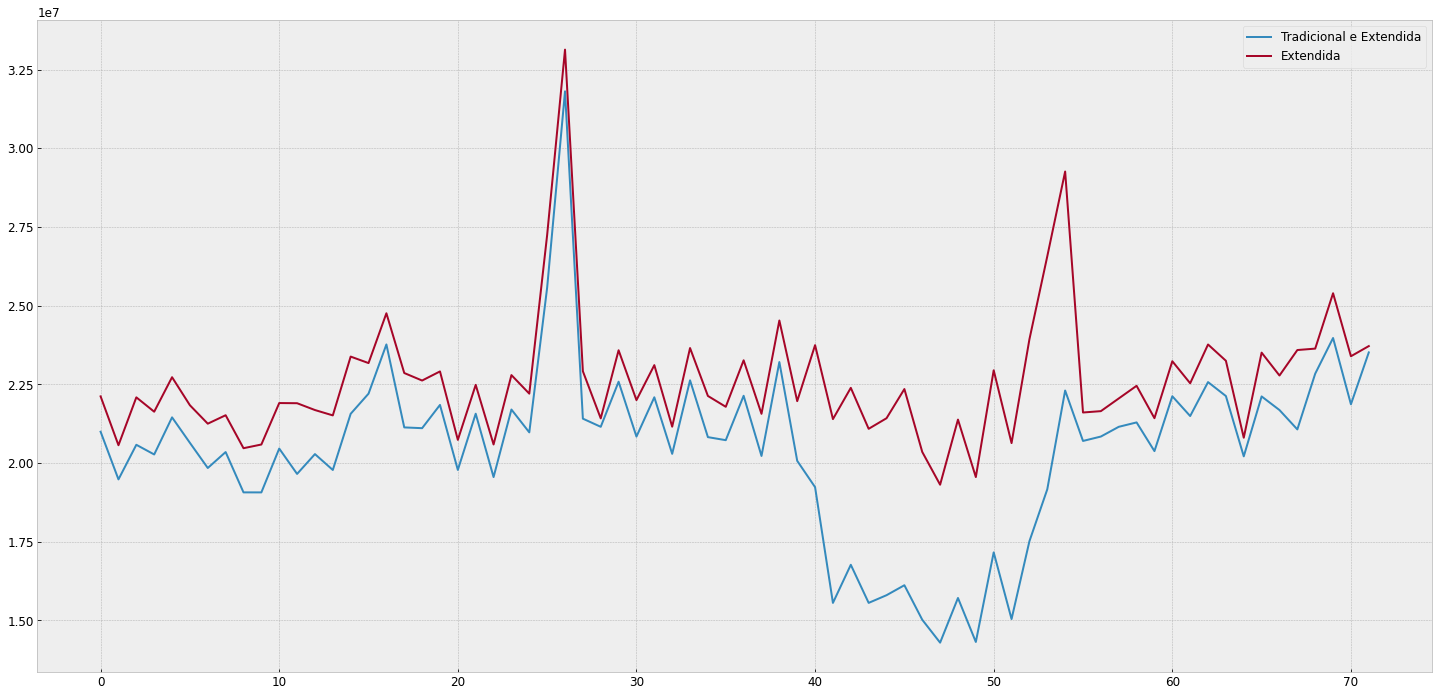

In [33]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1 )][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0 )][['year_week','sales']].groupby('year_week').sum().reset_index()
aux1.plot(ax = ax)
ax.legend( labels = ['Tradicional e Extendida','Extendida'])

### **H6.** Openned stores during the christmans holiday should have more sales
**Refuted** Stores doesn't have more sales in the christmas holiday.

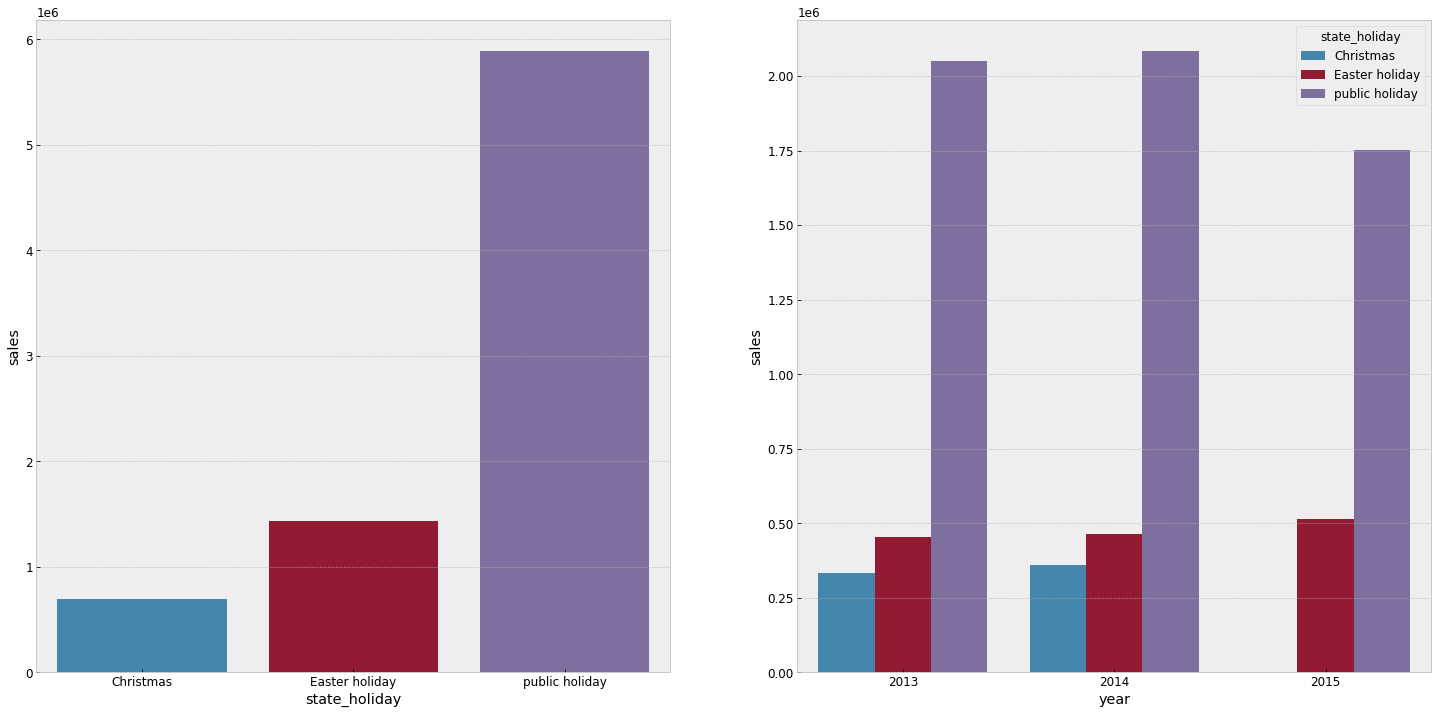

In [34]:
plt.subplot(1,2,1)
aux1 = df4[df4['state_holiday'] != 'regular day'][['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1,2,2)
aux2 = df4[df4['state_holiday'] != 'regular day'][['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2);                                                  

### **H7.** The sales should increase along years
**Refuted** Stores have less sales along years

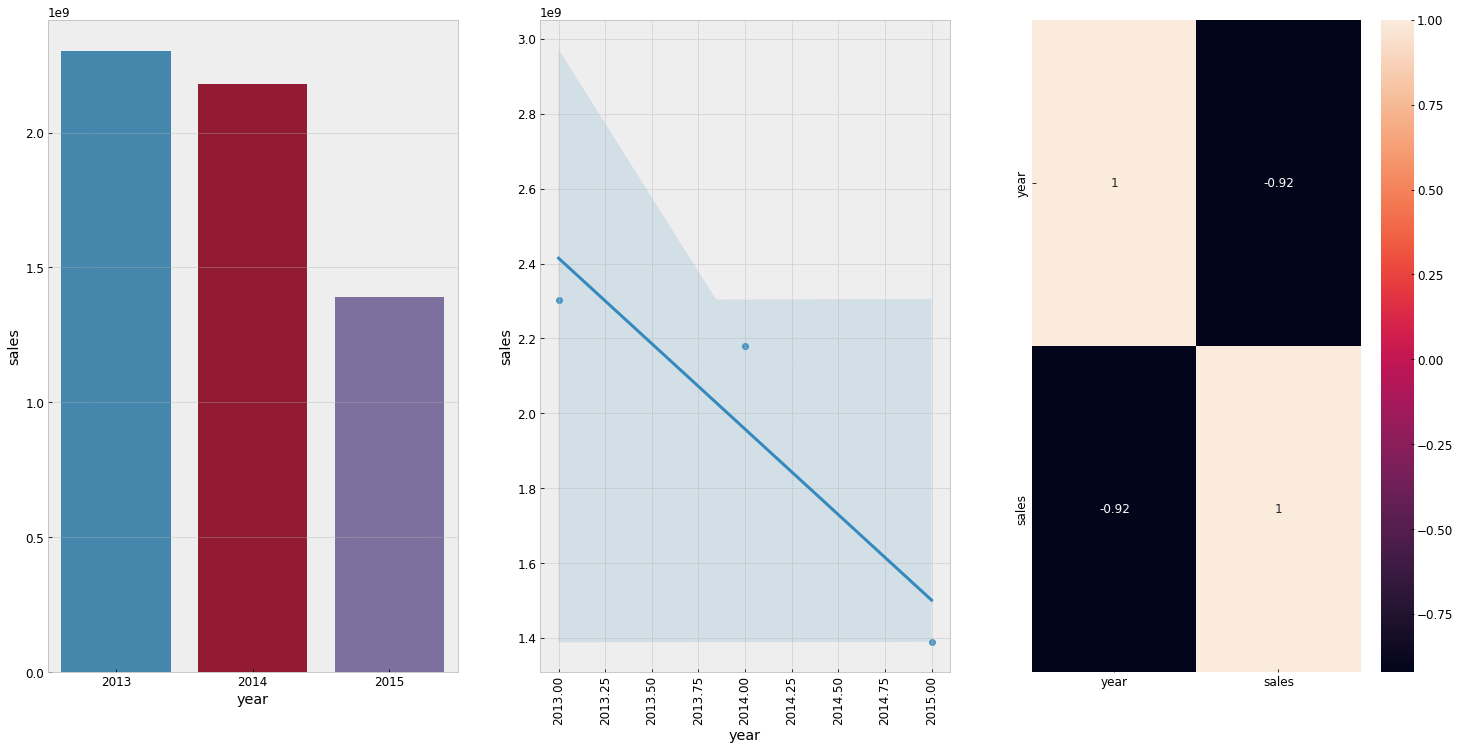

In [35]:
plt.subplot(1, 3, 1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
sns.regplot(x = 'year', y = 'sales', data = aux1);
plt.xticks(rotation = 90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### **H8.** The sales should be higher in the second semestrer of the year
**Refuted** Stores have less sales in the second semester

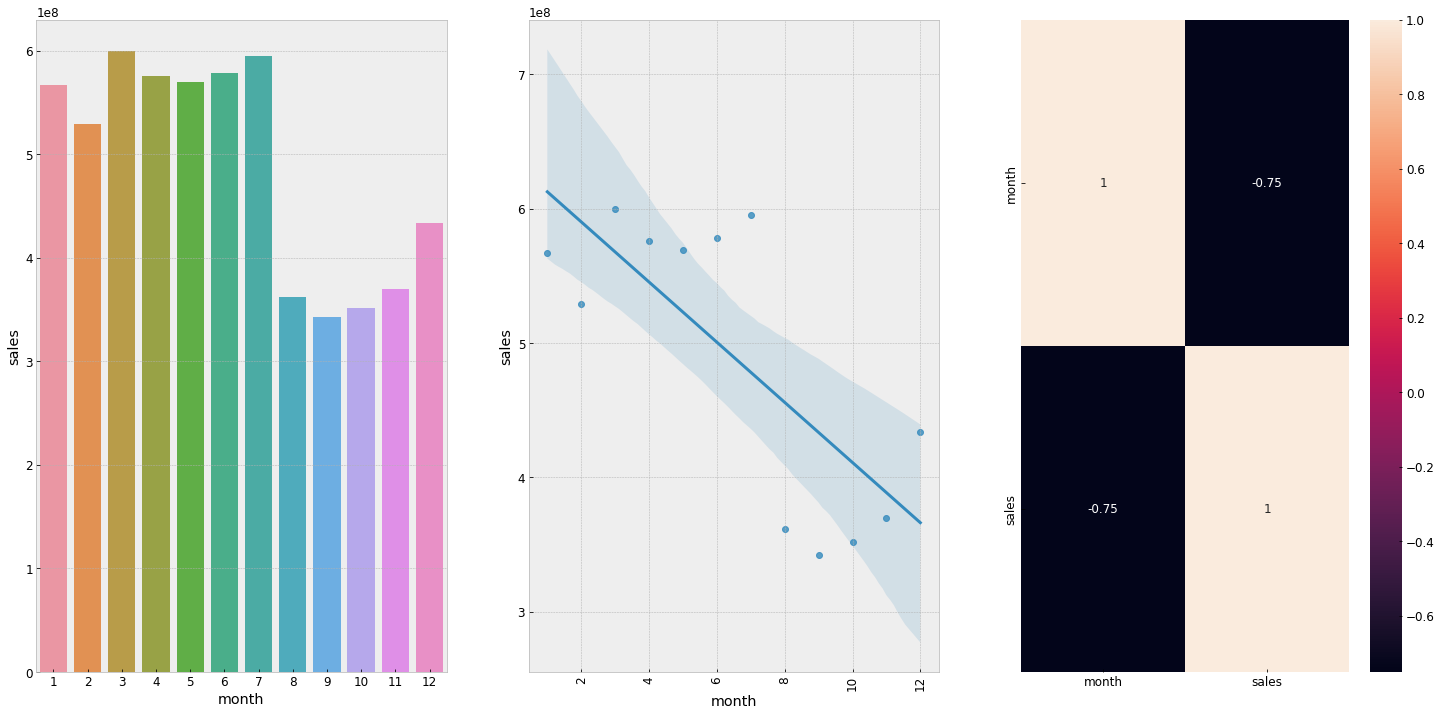

In [36]:
plt.subplot(1, 3, 1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
sns.regplot(x = 'month', y = 'sales', data = aux1);
plt.xticks(rotation = 90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### **H9.** The sales should be higher in days after 10.
**Refuted** Stores doesn't have more sales in the days after 10.

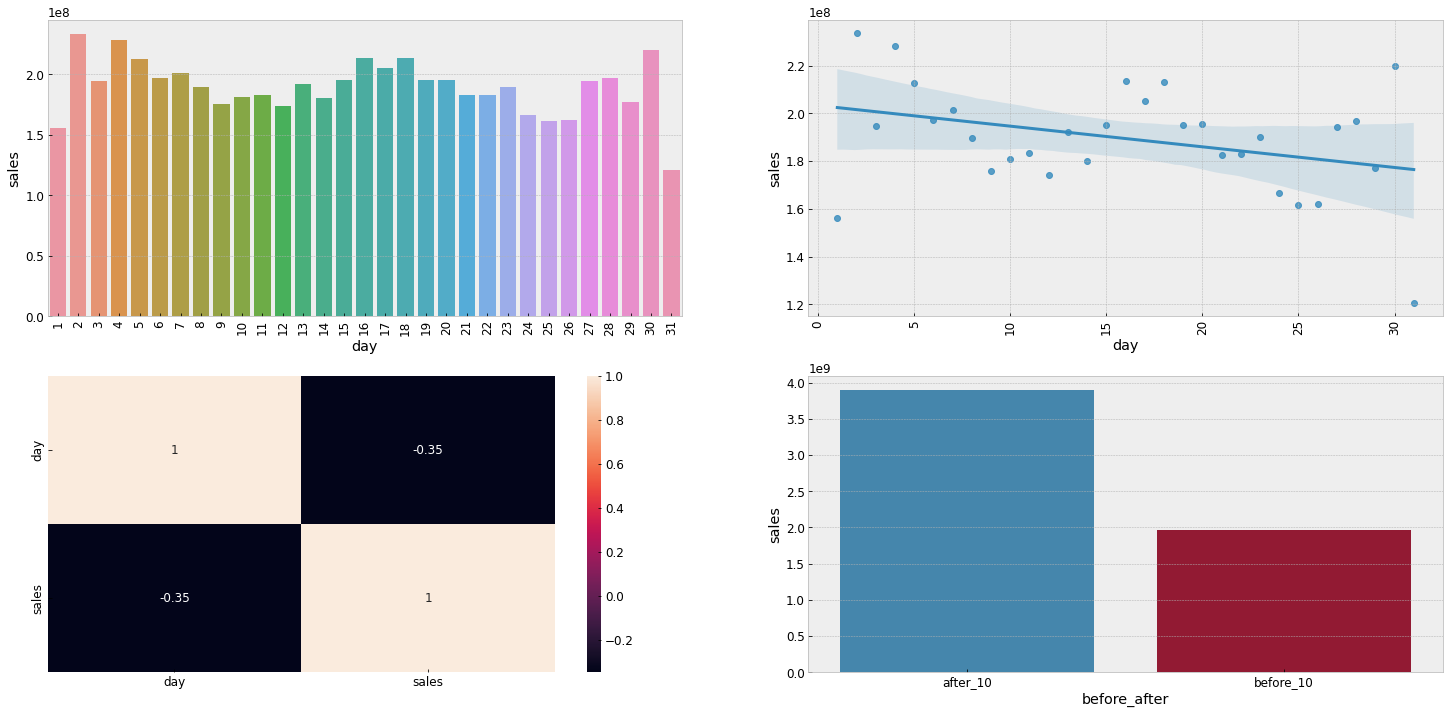

In [37]:
plt.subplot(2, 2, 1)
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x = 'day', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(2, 2, 2)
sns.regplot(x = 'day', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

plt.subplot(2, 2, 4)
aux1['before_after'] =  aux1['day'].apply( lambda x: 'before_10' if x <= 10 else 'after_10')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y = 'sales', data = aux2);

### **H10.** The sales shuould be lower in the weekends.
**True** Stores have less sales in the weekends.

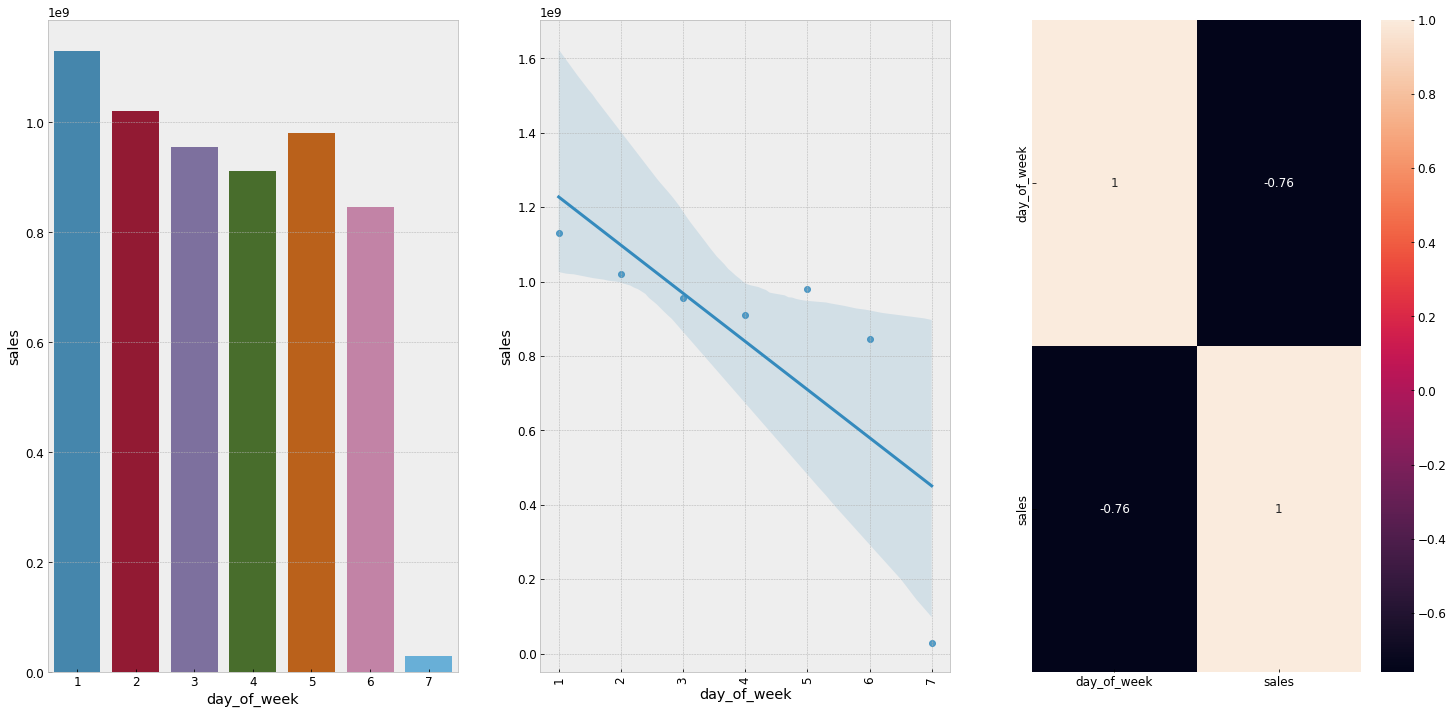

In [38]:
plt.subplot(1, 3, 1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1);
plt.xticks(rotation = 90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### **H11.** The sales shuould be lower in schools holydays.
**True** Stores have less sales in the school holiday. Except in july and august.

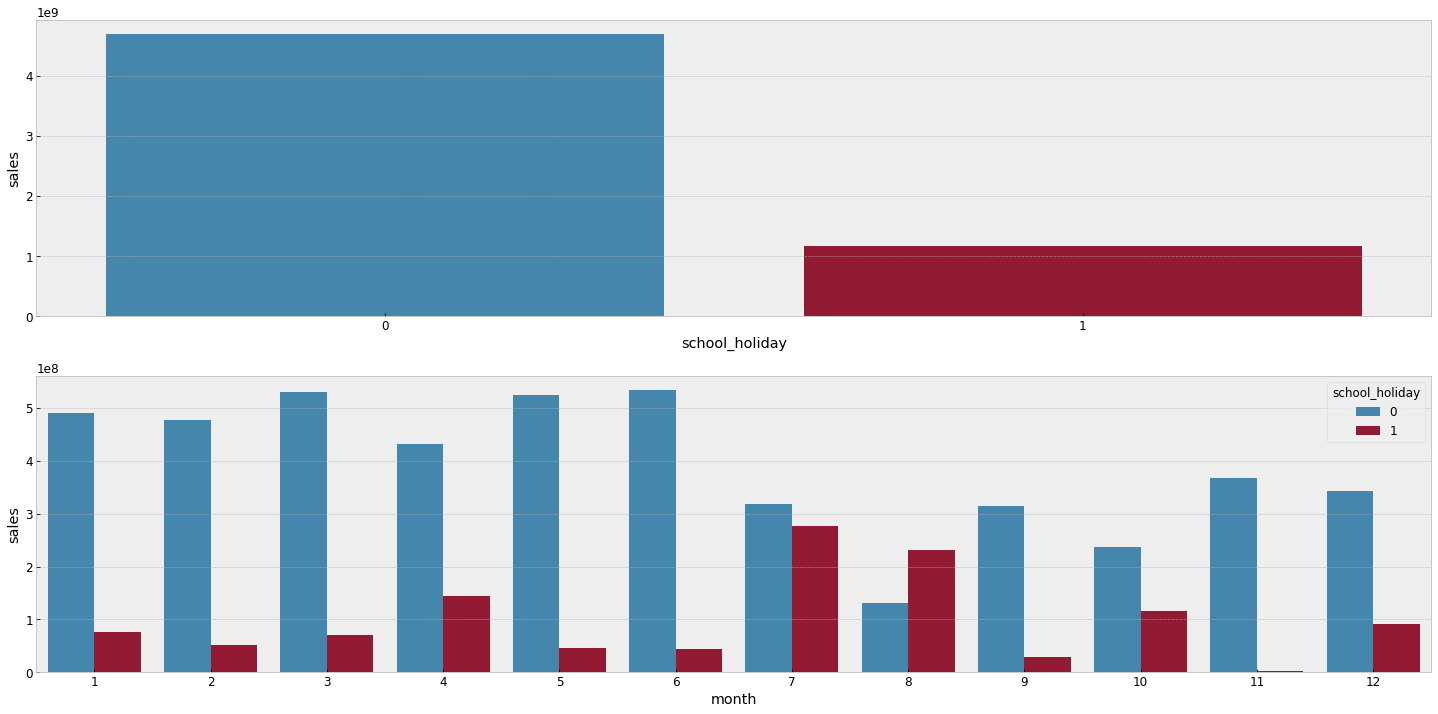

In [39]:
plt.subplot(2, 1 , 1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

plt.subplot(2, 1 , 2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x = 'month', y = 'sales',hue='school_holiday', data = aux2);



In [40]:
com = df4[df4['school_holiday'] == 1]['sales'].sum()/df4[df4['school_holiday'] == 1]['sales'].count()
sem = df4[df4['school_holiday'] == 0]['sales'].sum()/df4[df4['school_holiday'] == 0]['sales'].count()
print(com, sem)

7200.710281746153 6897.20783001147


### 4.2.1 Summary of Hipothesis

In [41]:
tab = [['Hipothesi','Conclusion','Importance'],
        ['H1','Refuted','Baixa'],
        ['H2','Refuted','Baixa'],
        ['H3','Refuted','Baixa'],
        ['H4','Refuted','Baixa'],
        ['H5','Refuted','Baixa'],
        ['H6','Refuted','Baixa'],
        ['H7','Refuted','Alta'],
        ['H8','Refuted','Alta'],
        ['H9','Refuted','Baixa'],
        ['H10','True','Alta'],
        ['H11','True','Baixa'],]

print(tabulate( tab, headers = 'firstrow'))

Hipothesi    Conclusion    Importance
-----------  ------------  ------------
H1           Refuted       Baixa
H2           Refuted       Baixa
H3           Refuted       Baixa
H4           Refuted       Baixa
H5           Refuted       Baixa
H6           Refuted       Baixa
H7           Refuted       Alta
H8           Refuted       Alta
H9           Refuted       Baixa
H10          True          Alta
H11          True          Baixa


## 4.3 Análise Multivariada

### 4.3.1 Numerical Atribute

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,promo2,is_promo
store,1.000000,-0.000008,0.005126,0.024325,-0.000047,0.000058,0.000641,-0.007072,0.008488,0.004901
day_of_week,-0.000008,1.000000,-0.462125,-0.386445,-0.528963,-0.392925,-0.205388,0.000003,0.000168,-0.004463
sales,0.005126,-0.462125,1.000000,0.894711,0.678472,0.452345,0.085124,-0.022419,-0.091040,-0.042084
customers,0.024325,-0.386445,0.894711,1.000000,0.616768,0.316169,0.071568,-0.056468,-0.150159,-0.067380
open,-0.000047,-0.528963,0.678472,0.616768,1.000000,0.295042,0.086171,0.002655,-0.008309,0.000132
promo,0.000058,-0.392925,0.452345,0.316169,0.295042,1.000000,0.067483,-0.000020,-0.000983,0.004161
school_holiday,0.000641,-0.205388,0.085124,0.071568,0.086171,0.067483,1.000000,-0.002177,-0.006909,0.020815
competition_distance,-0.007072,0.000003,-0.022419,-0.056468,0.002655,-0.000020,-0.002177,1.000000,-0.072646,-0.032774
promo2,0.008488,0.000168,-0.091040,-0.150159,-0.008309,-0.000983,-0.006909,-0.072646,1.000000,0.445582
is_promo,0.004901,-0.004463,-0.042084,-0.067380,0.000132,0.004161,0.020815,-0.032774,0.445582,1.000000


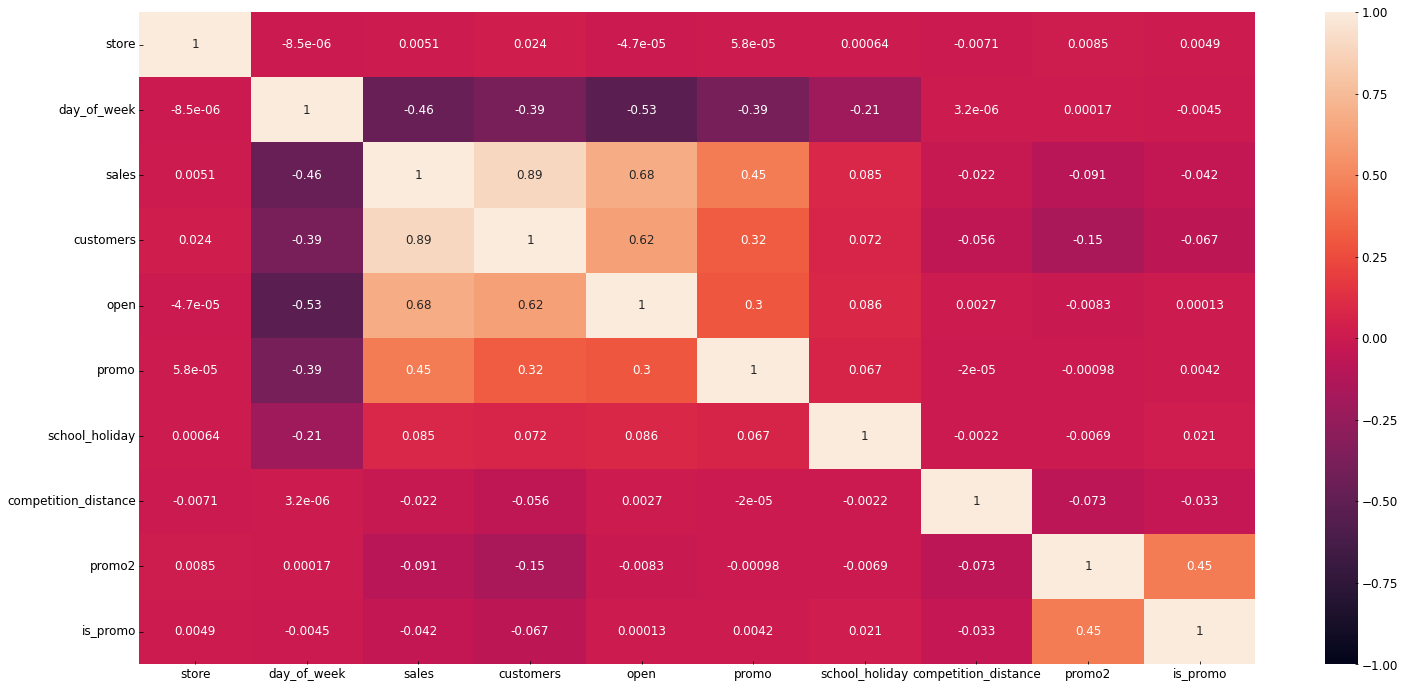

In [42]:
correlation = num_atributes.corr( method = 'pearson')
sns.heatmap( correlation, annot = True, vmin = -1, vmax = 1);
correlation

### 4.3.2 Categorical Atributes

In [43]:
a.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
63559,5,4,2015-06-04,5807,1,public holiday,0,a,basic,29910.0,4,2015,0,23,2015,0,2015,6,4,23,2015-22,2015-04-01,2,2015-06-01,0
63560,6,4,2015-06-04,5749,1,public holiday,0,a,basic,310.0,12,2013,0,23,2015,0,2015,6,4,23,2015-22,2013-12-01,18,2015-06-01,0
63609,55,4,2015-06-04,5984,1,public holiday,0,a,basic,720.0,11,2004,0,23,2015,0,2015,6,4,23,2015-22,2004-11-01,128,2015-06-01,0
63611,57,4,2015-06-04,9301,1,public holiday,0,d,extended,420.0,6,2014,0,23,2015,0,2015,6,4,23,2015-22,2014-06-01,12,2015-06-01,0
63614,60,4,2015-06-04,10399,1,public holiday,0,d,extended,5540.0,10,2009,0,23,2015,0,2015,6,4,23,2015-22,2009-10-01,69,2015-06-01,0


In [44]:
a = df4.select_dtypes( include = 'object')

# Calculate cramer_v
a1 = v_cramer( a['state_holiday'], a['state_holiday'])
a2 = v_cramer( a['state_holiday'], a['store_type'])
a3 = v_cramer( a['state_holiday'], a['assortment'])

a4 = v_cramer( a['store_type'], a['state_holiday'])
a5 = v_cramer( a['store_type'], a['store_type'])
a6 = v_cramer( a['store_type'], a['assortment'])

a7 = v_cramer( a['assortment'], a['state_holiday'])
a8 = v_cramer( a['assortment'], a['store_type'])
a9 = v_cramer( a['assortment'], a['assortment'])

d = pd.DataFrame({'staty_holiday':[a1,a2,a3],'store_type':[a4,a5,a6],'assortment':[a7,a8,a9]})
d.set_index(d.columns, inplace = True)

<AxesSubplot:>

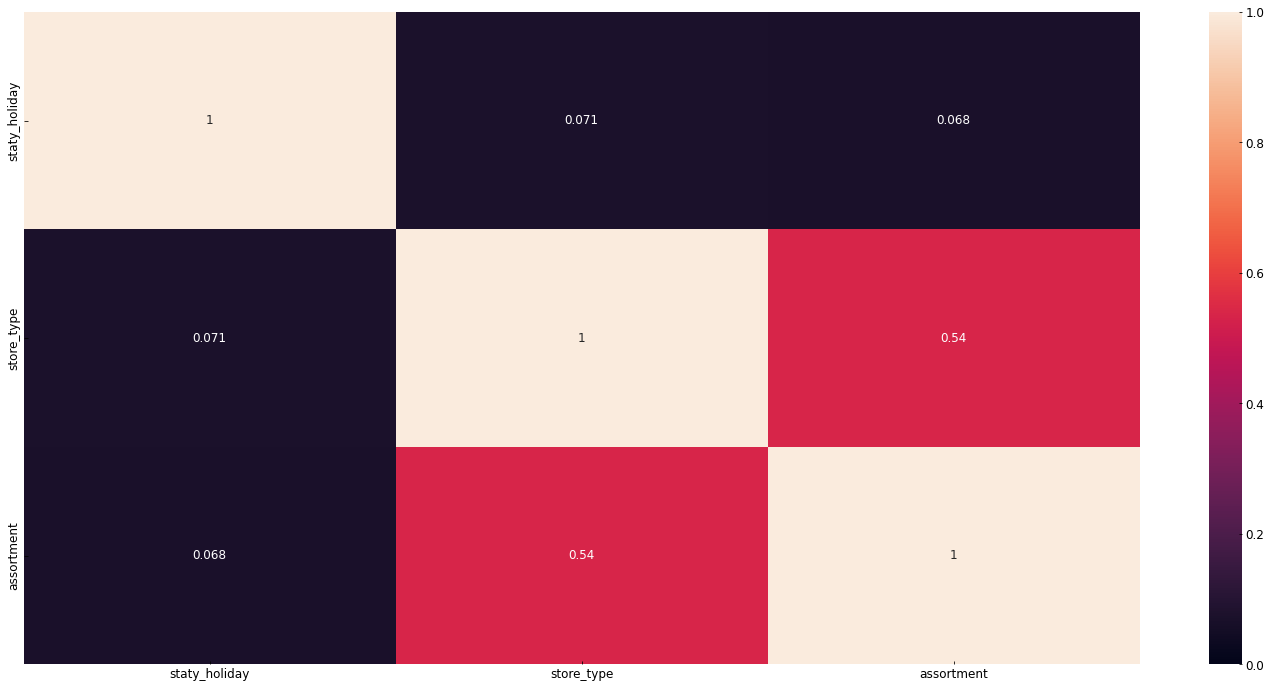

In [45]:
sns.heatmap(d, annot = True, vmin = 0, vmax = 1)

# 5.0. PASSO 5.0 - DATA PREPARATION

In [102]:
df5 = df4.copy()

## 5.1 Normalization
From secssion 4.1 there aren't variable wtih normal distribuction. So we will spik normalization.

## 5.2 Rescaling

In [103]:
a = df5.select_dtypes( include = ['int64', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,promo2,is_promo,year,month,day,week_of_year
0,1,5,5263,1,1,1270.0,0,0,2015,7,31,31
1,2,5,6064,1,1,570.0,1,1,2015,7,31,31
2,3,5,8314,1,1,14130.0,1,1,2015,7,31,31
3,4,5,13995,1,1,620.0,0,0,2015,7,31,31
4,5,5,4822,1,1,29910.0,0,0,2015,7,31,31


C:\Users\eliel\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

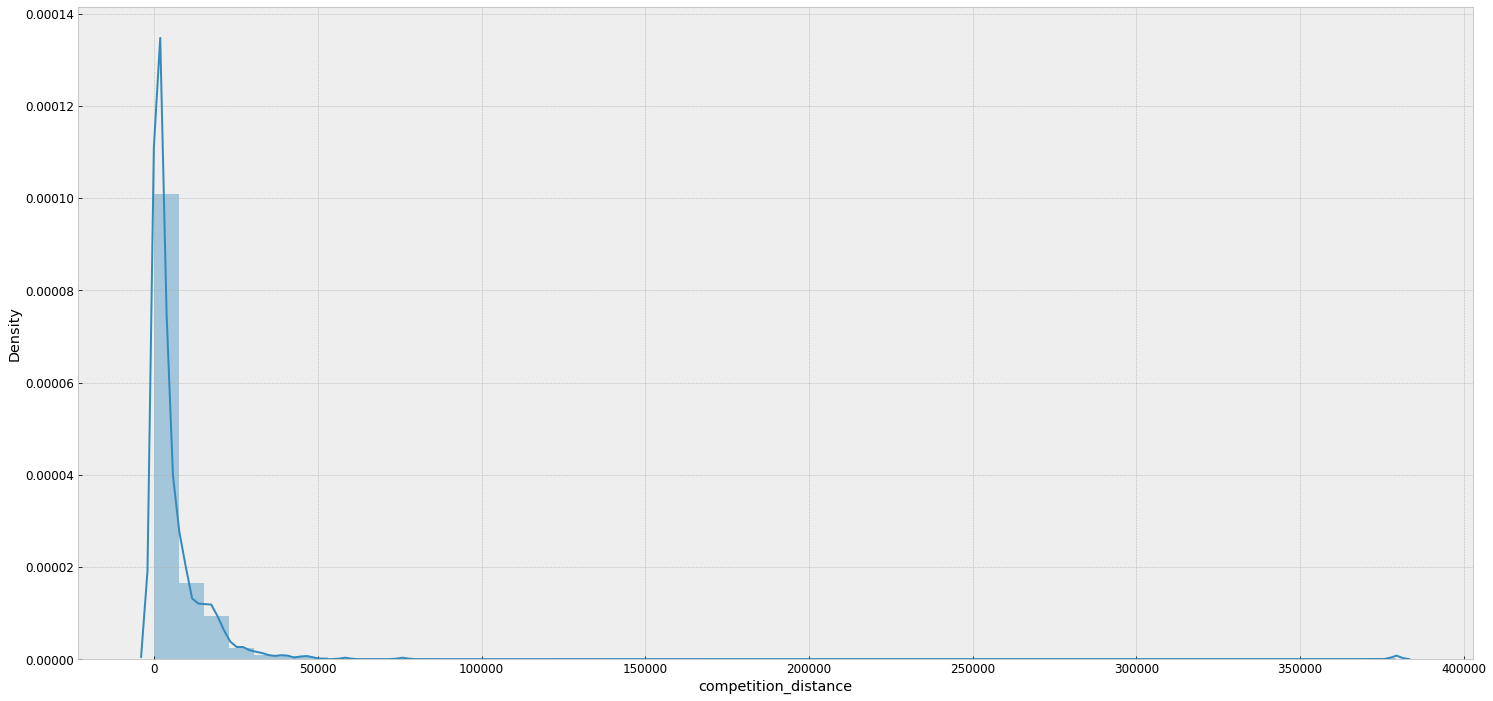

In [104]:
# sns.boxplot(data= a[['competition_distance'],'year','competition_time_month','promo_time_week']])
sns.distplot(a['competition_distance'])

In [105]:
rs = RobustScaler()
mms = MinMaxScaler()
# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values )
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values )
pickle.dump(rs, open('parameter/promo_time_week_scaler.pkl', 'wb'))
# year 
df5['year'] = mms.fit_transform(df5[['year']].values )
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

## 5.3 Data Transform

### 5.3.1 Data Encoding

In [99]:
# state_holiday -  One Hot Encoding
df5 = pd.get_dummies(df5, prefix = ['sh'], columns = ['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extended':2, 'extra':3}
df5['assortment'] = df5['assortment'].map( assortment_dict)

### 5.3.2 Response Variable Transformation

In [51]:
df5['sales'] = np.log1p(df5['sales'])

C:\Users\eliel\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


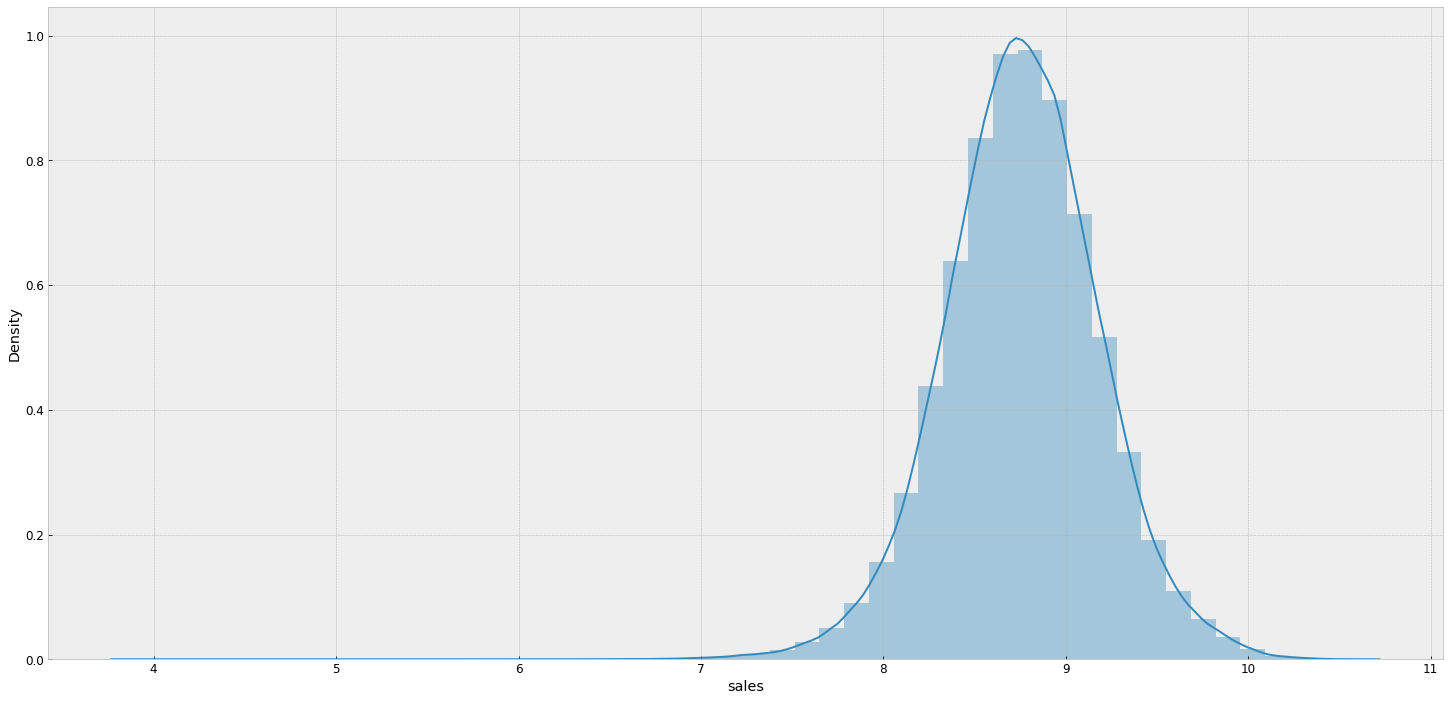

In [52]:
sns.distplot( df5['sales']);

In [53]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(2 * np.pi * x / 7))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(2 * np.pi * x / 7))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(2 * np.pi * x / 12))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(2 * np.pi * x / 12))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(2 * np.pi * x / 30))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(2 * np.pi * x / 30))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(2 * np.pi * x / 52))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(2 * np.pi * x / 52))

# 6.0 PASSO 6.0 SELAÇÃO DE VARIÁVEIS

**Por que o como selecionar variáveis**   
**Por que:** Para descobrir as variáveis mais relevantes para o modelo. Por relevantes entende-se, as variáveis que melhor explicam o fenômeno, ou a variável target.      
**Como:** O seleção de variáveis pode ser feitos de várias formas e com vários critórios. Abaixo estão listados alguns exemplos.

## 6.1 Tipo de seleção de variáveis

### 6.1.1 Seleção Univariada (Filter Methods)

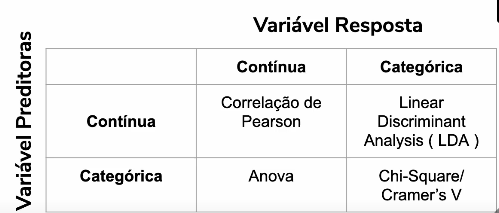
Este método tem uma grande desvantagem de não considerar a relação entre as variáveis. Descartar uma variável por esse método por ser um erro, visto que a variável sozinha pode não ter relavância para o modelo. Mas se combinada com outra variável pode ser muito relevante para o modelo.

### 6.1.2 Seleção por Importância (Embedded Methods)
Este método utiliza algoritmos para determinar a importância das variáveis. Os mais utilizados são **Random Forest e Regularização (LASSO E RIDGE)**. A estratégia é rodar os algorítimos e selecionar as features com maiores importâncias determinadas pelos algoritmos.

### 6.1.3 Seleção por SubaSets (Wrapper Methods)

In [54]:
df6 = df5.copy()

In [55]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since']
df6.drop(cols_drop, axis = 1, inplace = True)

In [56]:
# Train, Test split. 

# Training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('Test Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

X_train_n = X_train.drop(['date','sales'], axis = 1).values
y_train_n = y_train.values.ravel()

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00
Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### 6.1.4 Boruta as Features Selector
Algoritmo de seleção de features.   
Os códigos foram comentados por que demoram de 4 a 5 horas para rodar. A saida deste alguritmo está na seção 6.1.5

In [57]:
# # Instaciating a new Random Forest Regressor
# rf = RandomForestRegressor(n_jobs = -1)

# # Instaciatgin a new Boruta 
# boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42)
# boruta.fit(X_train_n, y_train_n)


In [58]:
# cols_selected = boruta.support_.tolist()

# # Selectec columns boruta
# X_train_fs = X_train.drop(['date','sales'], axis = 1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# # Not selected columns boruta
# cols_not_selected_boruta = list( np.setdiff1d(X_train.columns, cols_selected_boruta))

### 6.1.5 Best Features Boruta

In [59]:
# Selectec columns boruta
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin', 
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0 PASSO 7.0 -MACHINE LEARNING MODELLING

In [60]:
df7 = df6.copy()

In [61]:
# Adding sales and date to columns selected by boruta.
add_features = ['date','sales']
cols_selected_boruta_full = cols_selected_boruta.copy()

In [62]:
cols_selected_boruta_full.extend(add_features)

In [63]:
x_training = X_train[ cols_selected_boruta_full]

In [64]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

## 7.1 Average Model

In [65]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

In [66]:
# Prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns = {'sales':'predictions'})
aux1 = pd.merge( aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['predictions']

In [67]:
# Performance
baseline_result = ml_error('Averege Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Averege Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [68]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regressor', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regressor,1858.945187,0.291314,2662.972482


In [69]:
# lr_result_cv = cross_validation(x_training, 5, 'Linear Regression Regularized', lr)
# lr_result_cv

## 7.3 Linear Regression Regularized Model

In [70]:
# model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regressor - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regressor - Lasso,1890.440536,0.289157,2743.941899


### 7.3.1 Linear Regression Regularized Model - Cross Validatoin

In [71]:
# lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression Regularized', lrr)
# lrr_result_cv

## 7.4 Random Forest Regressor

In [72]:
# model
rf = RandomForestRegressor(n_estimators = 20, max_depth = 50,  random_state = 42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,695.118271,0.102154,1035.24297


### 7.4.1 Random Forest Model - Cross Validatoin

In [73]:
# rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf)
# rf_result_cv

## 7.5 XGBoost Regressor

In [74]:
# model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = 100,
                             eta = 0.1,
                             max_depth = 10,
                             subsample = 0.7,
                             closample_bytree = 0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

C:\Users\eliel\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:19:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "closample_bytree" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,864.842658,0.126081,1278.785979


### 7.5.1 XGBoost Model - Cross Validatoin

In [75]:
# xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb)
# xgb_result_cv

## 7.6 Compare Models Performance

In [76]:
modeling_results = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modeling_results.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,695.118271,0.102154,1035.242970
0,XGBoost Regressor,864.842658,0.126081,1278.785979
0,Averege Model,1354.800353,0.455051,1835.135542
0,Linear Regressor,1858.945187,0.291314,2662.972482
0,Linear Regressor - Lasso,1890.440536,0.289157,2743.941899


## 7.7 Cross Validation Method Performance Comparison

In [77]:
# modeling_results_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
# modeling_results_cv.sort_values('RMSE CV')

  # 8.0 PASSO 8.0 - HYPERPAREMETER FINE TUNING

# 8.0 PASSO 8.0 - RANDOM SEARCH

In [78]:
# param = {'n_estimators':[1500, 1700, 2500, 3000, 3500],
#          'eta':[0.01, 0.03],
#          'max_depth':[3, 5, 10],
#          'subsample':[0.1, 0.5, 0.7],
#          'colsample_bytree':[0.3, 0.7, 0.9],
#          'min_child_weight':[3, 8, 15]}
# MAX_EVAL = 5
# warnings.filterwarnings('ignore')

In [79]:
# final_result = pd.DataFrame()
# # model
# for i in range(MAX_EVAL):
#     # choose values for parameters randomly
#     hp = {k: v[randint(0,len(v))] for k, v in param.items()}
#     print(hp)
    
#     # model
#     model_xgb = xgb.XGBRegressor(#objecitve = 'reg:squarederror',
#                                  n_estimators = hp['n_estimators'],
#                                  eta = hp['eta'], 
#                                  max_depth = hp['max_depth'],
#                                  subsample = hp['subsample'],
#                                  #closample_bytree = hp['colsample_bytree'],
#                                  min_child_weight = hp['min_child_weight'])

#     # performance
#     xgb_result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb)
#     final_result = pd.concat([final_result, xgb_result])
# final_result

In [80]:
param_tuned = {'n_estimators': 1700,
               'eta': 0.03,
               'max_depth': 10,
               'subsample': 0.7,
               'colsample_bytree': 0.7,
               'min_child_weight': 8}

In [81]:
print(datetime.datetime.now())
model_xgb_tuned = xgb.XGBRegressor(objecitve = 'reg:squarederror',
                                 n_estimators = param_tuned['n_estimators'],
                                 eta = param_tuned['eta'], 
                                 max_depth = param_tuned['max_depth'],
                                 subsample = param_tuned['subsample'],
                                 closample_bytee = param_tuned['colsample_bytree'],
                                 min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
print(datetime.datetime.now())
xgb_result_tuned

2022-05-18 14:20:06.064500
[14:20:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "closample_bytee", "objecitve" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\eliel\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


2022-05-18 14:29:34.967953


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,625.389668,0.090333,917.801491


# 9.0 PASSO 9.0 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [83]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1( yhat_xgb_tuned )

C:\Users\eliel\AppData\Local\Temp\ipykernel_25204\1546619500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
C:\Users\eliel\AppData\Local\Temp\ipykernel_25204\1546619500.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( yhat_xgb_tuned )


## 9.1 Business Performance

In [84]:
# sum of predictions
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAE'})  
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAPE'})  

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store')
df92 = pd.merge(df91, df9_aux3, how = 'inner', on = 'store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [85]:
df92.sort_values('MAPE', ascending = False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,103310.562500,100009.043264,106612.081736,3301.519236,0.542061
908,909,233834.250000,226281.477157,241387.022843,7552.772843,0.508798
875,876,200100.984375,196073.640774,204128.327976,4027.343601,0.298668
594,595,381003.468750,376997.805875,385009.131625,4005.662875,0.271318
549,550,239308.218750,238031.826159,240584.611341,1276.392591,0.242645


<AxesSubplot:xlabel='store', ylabel='MAPE'>

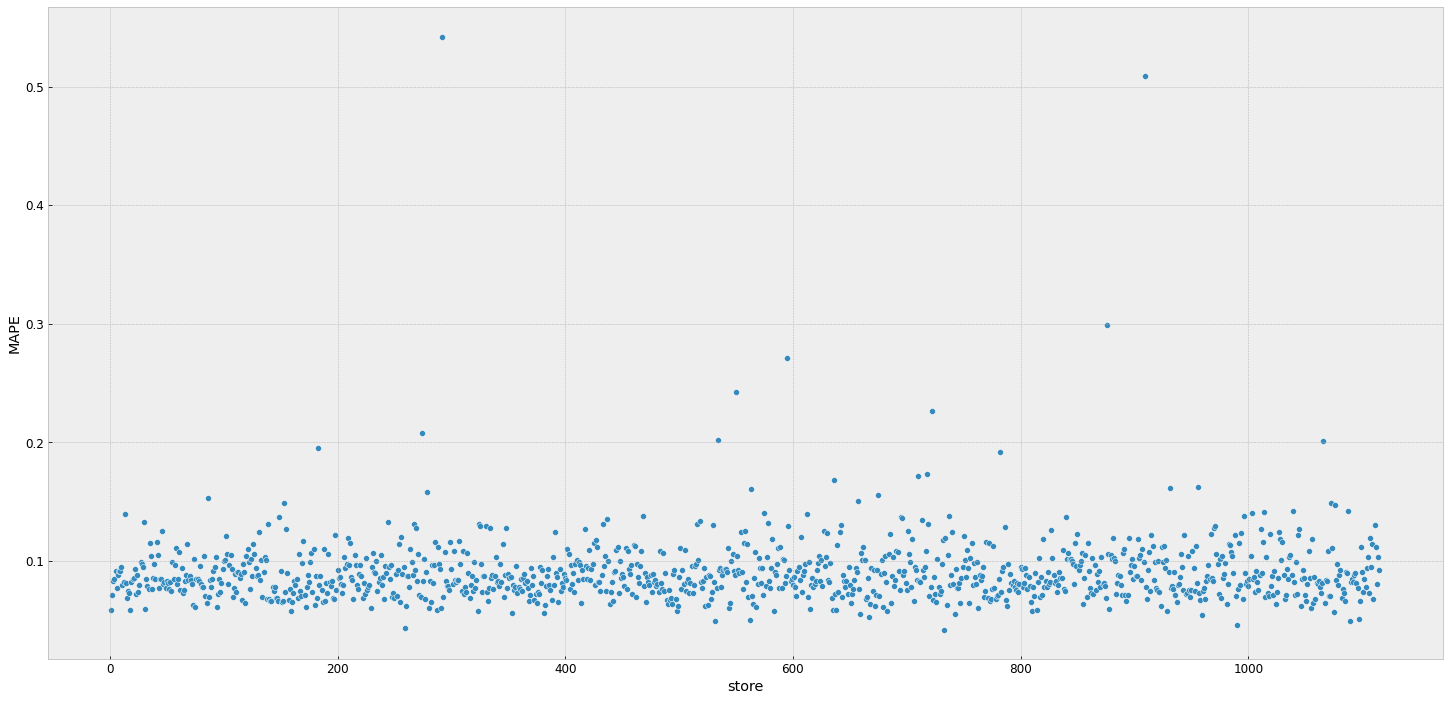

In [86]:
sns.scatterplot(x = 'store', y = 'MAPE', data = df92)

In [87]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
537,538,138073.375000,137725.975883,138420.774117,347.399117,0.088351
941,942,227810.906250,227160.662584,228461.149916,650.243666,0.095243
402,403,257464.296875,256652.581649,258276.012101,811.715226,0.105716
30,31,208917.453125,208568.330223,209266.576027,349.122902,0.059311


  ## 9.2 Total Performance

In [88]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index':'Scenario', 0:'Values'})   
df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format) 
df93

,Scenario,Values
0,predictions,"R$ 282,283,456.00"
1,worst_scenario,"R$ 281,582,037.42"
2,best_scenario,"R$ 282,984,883.08"


## 9.3 Machine Learning Performance

In [89]:
df9['error'] =df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\eliel\AppData\Local\Temp\ipykernel_25204\3131681291.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] =df9['sales'] - df9['predictions']
C:\Users\eliel\AppData\Local\Temp\ipykernel_25204\3131681291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


C:\Users\eliel\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='predictions', ylabel='error'>

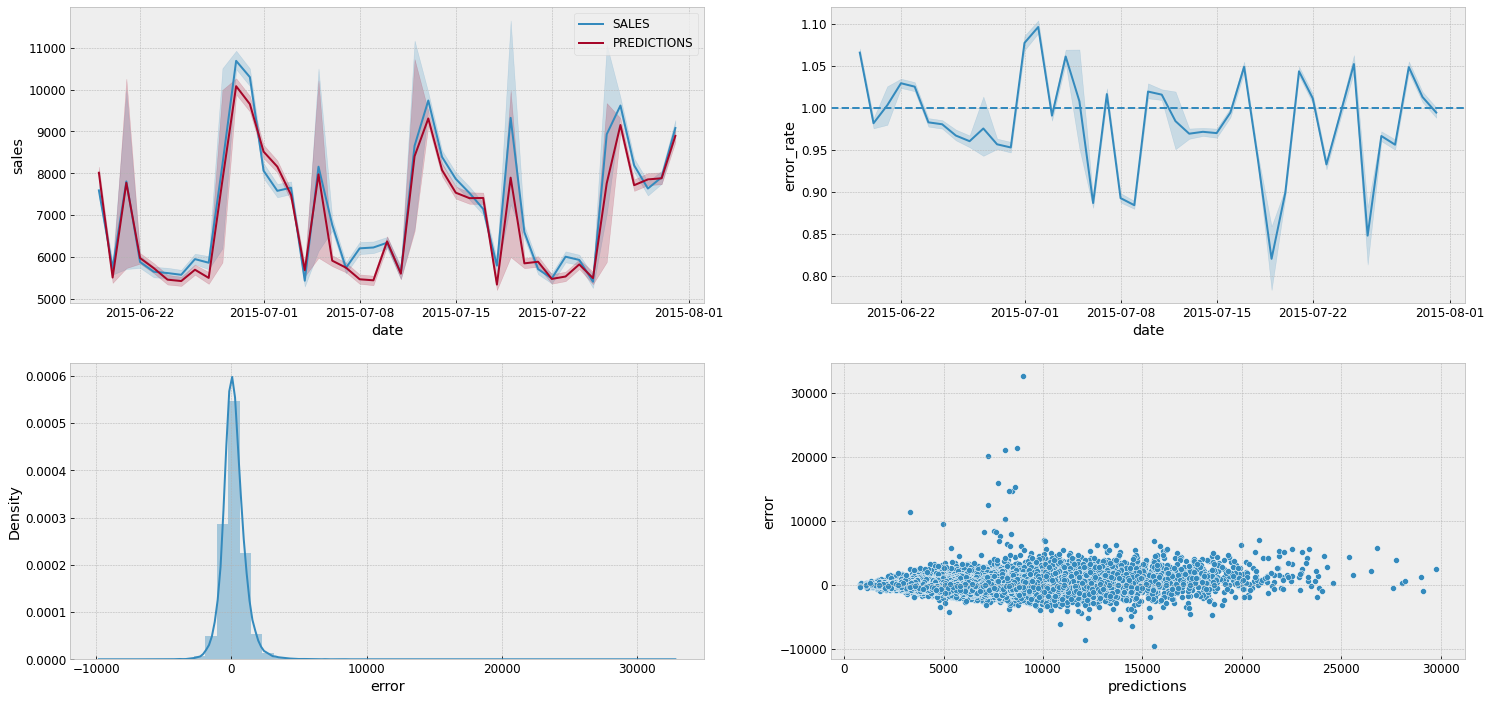

In [90]:
plt.subplot(2,2,1)
sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'SALES')
sns.lineplot(x = 'date', y = 'predictions', data = df9, label = 'PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x = 'date', y = 'error_rate', data = df9)
plt.axhline(1, linestyle= '--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(x = 'predictions', y = 'error', data = df9)

In [91]:
# Estudar análise de resíduo para melhoria da performance do modelo.

# 10.0 PASSO 10.0 - DEPLOY MODEL TO PRODUCTION

In [82]:
pickle.dump(model_xgb_tuned, open('model_rosmam.pkl', 'wb'))

## 10.1 Rossmann Class

In [101]:
class Rossmann(object):
    def __init__(self):
        self.competition_distance_scaler   = pickle.load(open('parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open('parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open('parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open('parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open('parameter/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):
        ## 1.1 Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 
                    'PromoInterval']

        snake_case = lambda x:  inflection.underscore( x ) # convert cammel casa para snake case
        cols_new = list( map( snake_case, cols_old))
        df1.columns = cols_new

        ## 1.3 Data Typers
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5 Fillout NA

        # competition_distance --> fill na by a very large distance 
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 5*df1['competition_distance'].max() if math.isnan( x ) else x)

        # competition_open_since_month  
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1 )  

        # competition_open_since_year    
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1 )  

        # promo2_since_week   
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1 )  

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1 )

        # promo_interval
        month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

        df1['promo_interval'].fillna(0, inplace = True)

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0  else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1 )

        ## 1.6 Change Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
    
        return df1
    
    def feature_engineering(self, df2):
        ### 2.2.5 Feature Engineering
        # year
        df2['year'] = df2['date'].dt.year

        # monthy
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
        df2['competition_time_month'] = ( (df2['date'] -  df2['competition_since'])/30 ).apply(lambda x: x.days).astype ( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( (lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7)))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype( int )

        # assortiment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular day')

        ## 3.1 Filtragem de linhas
        df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]

        ## 3.2 Seleção de colunas
        cols_drop = ['customers','open','promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis = 1)
        
        return df2

    def data_preparation(self, df5):
    
        ## 5.2 Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values )
        pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values )
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values )
        
        # year 
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values )

        ### 5.3.1 Data Encoding
        # state_holiday -  One Hot Encoding
        df5 = pd.get_dummies(df5, prefix = ['sh'], columns = ['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic':1, 'extended':2, 'extra':3}
        df5['assortment'] = df5['assortment'].map( assortment_dict)

        # Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(2 * np.pi * x / 7))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(2 * np.pi * x / 7))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(2 * np.pi * x / 12))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(2 * np.pi * x / 12))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(2 * np.pi * x / 30))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(2 * np.pi * x / 30))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(2 * np.pi * x / 52))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(2 * np.pi * x / 52))
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
                          'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin',  'day_of_week_cos',
                          'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]

## 10.3 API Tester